## Run 1

In [3]:
## LOADING DATA

import pickle

# Load ribociclib data from data/preprocessed 

with open('data/preprocessed/palbociclib_data.pkl', 'rb') as f:
    palbociclib_data = pickle.load(f)

FileNotFoundError: [Errno 2] No such file or directory: 'data/preprocessed/palbociclib_data.pkl'

In [2]:
import dynmarker.FeatureSelection as fs 

feature_data, label_data = fs.create_feature_and_label(palbociclib_data)

In [3]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, Normalizer
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import LinearSVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import cross_val_score, KFold, train_test_split
from sklearn.feature_selection import f_regression, SelectKBest
# from sklearn import set_config
# set_config(transform_output = "pandas")

import pandas as pd 

from functools import partial

scaler = Normalizer()
feature_selector = SelectKBest(score_func=f_regression, k=20)
model = ElasticNet()

scores, pval = f_regression(feature_data, label_data)
scores # score for each feature at their respective index

K = 20
mrmr_score_func = partial(fs.mrmr_select_fcq_sklearn, K=K)
mrmr_selector = SelectKBest(mrmr_score_func, k=K)


In [4]:
pipe = Pipeline([('feature_selector', feature_selector), ('regressor', model)])

scores = cross_val_score(pipe, feature_data, label_data, cv=5, scoring='neg_mean_squared_error')

print(f'NORM mean: {-scores.mean():.4f}, std: {scores.std():.4f}')

NORM mean: 1.7761, std: 0.0980


## Run 2 

In [1]:
## LOADING DATA

import pickle
import dynmarker.FeatureSelection as fs 

# Load palbociclib data from data/preprocessed 

with open('data/preprocessed/palbociclib_data.pkl', 'rb') as f:
    palbociclib_data = pickle.load(f)


In [2]:

feature_data, label_data = fs.create_feature_and_label(palbociclib_data)
y_std = label_data.std()
y_std


1.5952913449402224

In [8]:

import pandas as pd
import numpy as np 

from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, Normalizer
from sklearn.model_selection import cross_val_score, KFold, train_test_split
from sklearn.linear_model import LinearRegression, LogisticRegression, Lasso, ElasticNet
from sklearn.svm import LinearSVR, LinearSVC, SVC, SVR
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.neural_network import MLPRegressor, MLPClassifier
from sklearn.feature_selection import SelectKBest, f_regression, mutual_info_regression
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_squared_error, accuracy_score

from dynmarker.EvaluationPipeline import EvaluationPipeline
from dynmarker.FeatureSelection import example_run_model_func


In [9]:
random_eval = EvaluationPipeline()
random_eval.set_function(example_run_model_func)

In [10]:
random_eval.run_function(feature_data, label_data, 10, k_ranges=range(1,201,10), model_list=[LinearRegression(), Lasso(), ElasticNet()], n_cores=6)

--- Finished LinearRegression using 6 cores ---
--- Finished Lasso using 6 cores ---
--- Finished ElasticNet using 6 cores ---


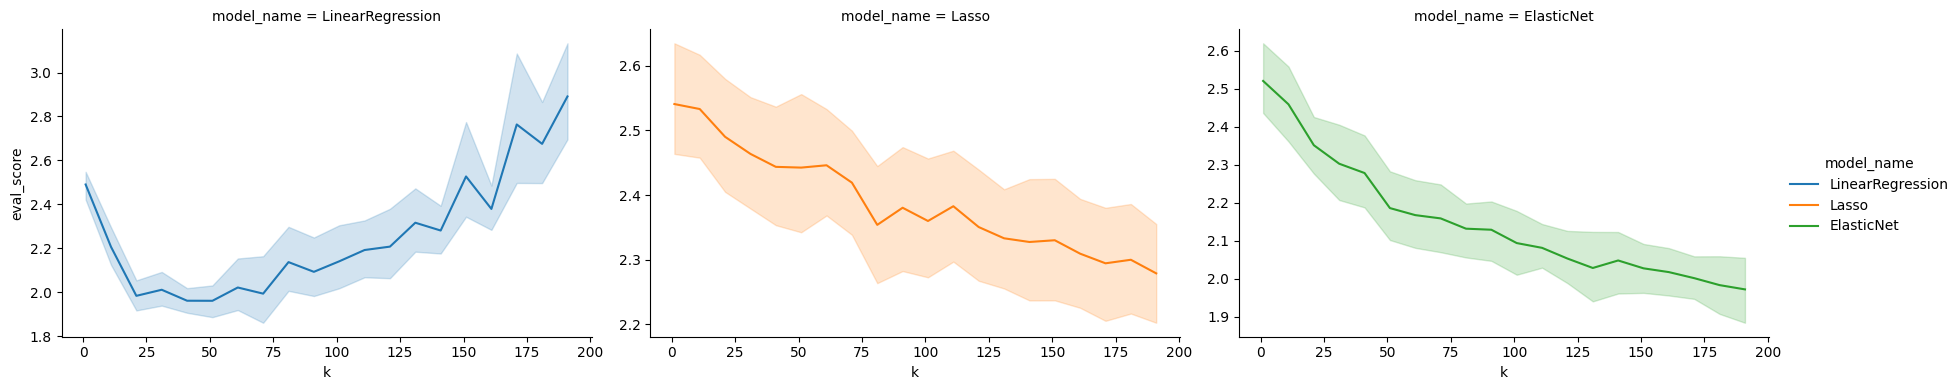

In [11]:
# plot a line plot the average score and std for each k value over the i iterations, show error bar as std

import matplotlib.pyplot as plt
import seaborn as sns

evaluation_df_lite = random_eval.evaluation_df

# get rid of the outliers, 20 times the value of the label data's standard deviation is the cut-off
processed_evaluation_df = evaluation_df_lite[evaluation_df_lite['eval_score'] < y_std*5]
# processed_evaluation_df = evaluation_df_lite

# plot each model on the different figure, multi-figure plot

g = sns.FacetGrid(processed_evaluation_df, col='model_name', col_wrap=3, hue='model_name', height=4, aspect=1.5, sharey=False)
g.map(sns.lineplot, 'k', 'eval_score')
g.add_legend()
# plt.grid()
plt.show()

In [12]:
# train test split using MLPRegressor

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(feature_data, label_data, test_size=0.2, random_state=42)

from sklearn.neural_network import MLPRegressor

mlp = MLPRegressor(hidden_layer_sizes=(100, 100, 100), max_iter=1000, random_state=42)
mlp.fit(X_train, y_train)

y_pred = mlp.predict(X_test)

from sklearn.metrics import mean_squared_error

score = mean_squared_error(y_test, y_pred)

print(score)

2.3337973445311193


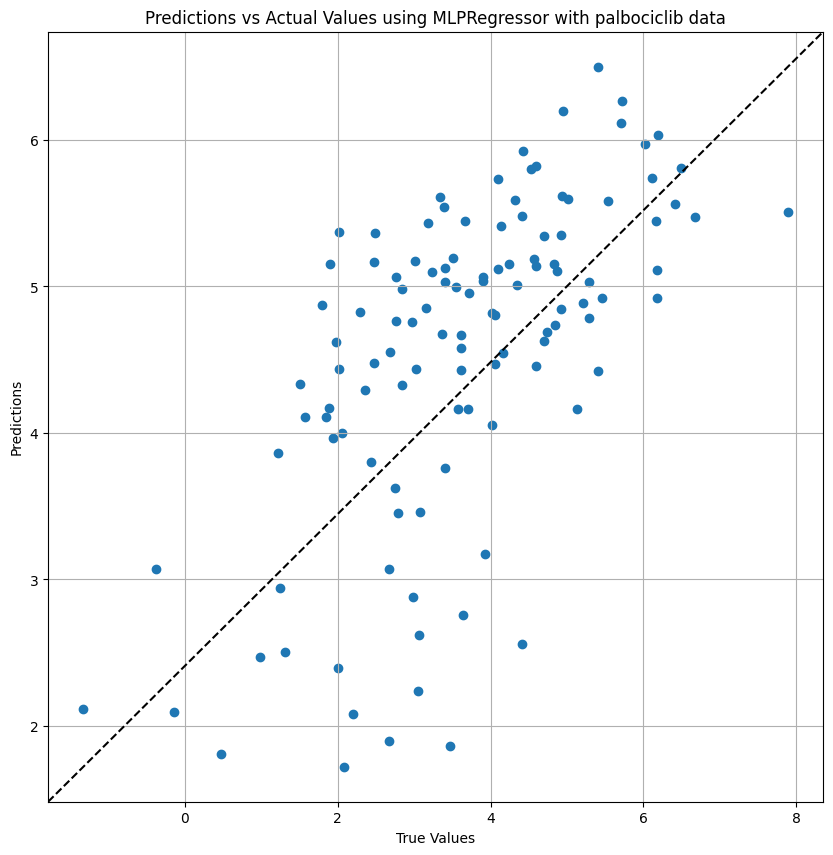

Correlation coefficient: 0.6294, p-value: 0.0000


In [24]:
# plot the predictions vs the actual values

import matplotlib.pyplot as plt

# add in a line of y=x

plt.figure(figsize=(10,10))
plt.plot([0, 1], [0, 1], transform=plt.gca().transAxes, ls='--', c='k')

# title
plt.title('Predictions vs Actual Values using MLPRegressor with palbociclib data')
plt.scatter(y_test, y_pred)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.grid()
plt.show()

# pearson correlation coefficient

from scipy.stats import pearsonr

corr, p_val = pearsonr(y_test, y_pred)

# print the correlation coefficient and p-value
print(f'Correlation coefficient: {corr:.4f}, p-value: {p_val:.4f}')



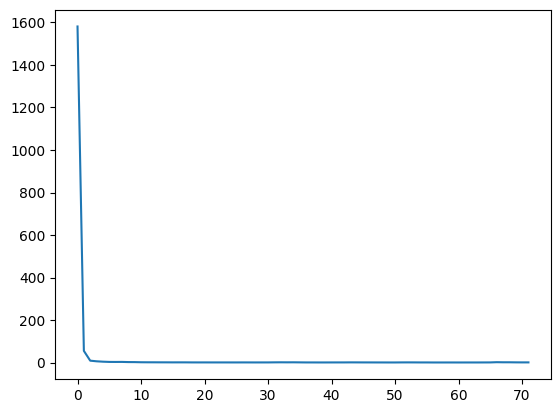

In [22]:
# show loss curve

plt.plot(mlp.loss_curve_)


## Feature Selection in mRNA expression data

In [1]:
import pandas as pd
import pickle

# import GDSC2 drug response data using pickle

with open('data/drug-response/GDSC2/cache_gdsc2.pkl', 'rb') as f:
    gdsc2 = pickle.load(f)
    gdsc2_info = pickle.load(f)

# import CCLE gene expression data using pickle

with open('data/gene-expression/CCLE_Public_22Q2/ccle_expression.pkl', 'rb') as f:
    gene_entrez = pickle.load(f)
    ccle = pickle.load(f)

# import CCLE sample info data using pickle

with open('data/gene-expression/CCLE_Public_22Q2/ccle_sample_info.pkl', 'rb') as f:
    ccle_sample_info = pickle.load(f)

# import STRING database using pickle

with open('data/protein-interaction/STRING/string_df.pkl', 'rb') as f:
    string_df = pickle.load(f)
    string_df_info = pickle.load(f)
    string_df_alias = pickle.load(f)

# with open('data/protein-interaction/STRING/ccle_to_string_id_df.pkl', 'rb') as f:
#     ccle_to_string_id_df = pickle.load(f)


In [2]:
import DataFunctions as utils

# get the drug response data for palbociclib
palbociclib_data = utils.create_joint_dataset_from_ccle_gdsc2('Palbociclib', gdsc2, ccle, ccle_sample_info)

feature_data, label_data = utils.create_feature_and_label(palbociclib_data)

In [3]:
feature_data.head()

,TSPAN6,TNMD,DPM1,SCYL3,C1orf112,FGR,CFH,FUCA2,GCLC,NFYA,...,H3C2,H3C3,AC098582.1,DUS4L-BCAP29,C8orf44-SGK3,ELOA3B,NPBWR1,ELOA3D,ELOA3,CDR1
SANGER_MODEL_ID,,,,,,,,,,,,,,,,,,,,,
SIDM00872,5.296090,0.000000,6.794416,3.452859,5.260778,0.042644,4.339137,5.833143,7.313246,4.764474,...,1.827819,0.000000,0.847997,1.704872,0.411426,0.000000,1.063503,0.0,0.000000,0.0
SIDM00866,5.214125,0.000000,6.328047,3.168321,4.654206,0.042644,0.432959,6.574102,5.140779,5.114783,...,0.000000,0.000000,0.298658,1.584963,0.695994,0.000000,2.693766,0.0,0.000000,0.0
SIDM00885,5.241840,0.201634,5.615299,3.090853,3.732269,0.084064,0.111031,4.026800,5.471513,6.019480,...,0.632268,0.000000,0.422233,1.250962,0.505891,0.111031,0.070389,0.0,0.111031,0.0
SIDM00884,3.481557,0.000000,7.070389,2.341986,3.679199,0.176323,3.420887,5.854494,5.976134,5.112283,...,2.327687,0.226509,0.650765,2.477677,0.000000,0.000000,0.042644,0.0,0.084064,0.0
SIDM00874,4.903038,0.000000,7.177719,2.744161,4.648465,0.150560,0.070389,5.819924,4.374344,3.814550,...,2.440952,1.695994,0.367371,1.505891,0.214125,0.137504,0.704872,0.0,0.000000,0.0


In [4]:
feature_data.shape

(584, 19221)

In [5]:
label_data.head()

SANGER_MODEL_ID
SIDM00872    4.887773
SIDM00866    5.065262
SIDM00885    4.133027
SIDM00884    3.310621
SIDM00874    5.586256
Name: LN_IC50, dtype: float64

In [6]:
# using f-regression to select the top 20 features 

from sklearn.feature_selection import SelectKBest, f_regression

selector = SelectKBest(f_regression, k=20)
selector.fit(feature_data, label_data)

# get the selected features

selected_features = feature_data.columns[selector.get_support()]

selected_features


Index(['WAS', 'BCAR1', 'NCKAP1', 'ARHGAP15', 'RPL3', 'TJP1', 'RASAL3',
       'AMOTL2', 'NCKAP1L', 'SDC4', 'LAMA5', 'SLC49A4', 'PTPRF', 'CD53',
       'TUFT1', 'PTPN7', 'PPIC', 'PXDC1', 'P2RY8', 'IKZF1'],
      dtype='object')

#### Simple run

score using selected features: 2.3816, score using all features: 2.3071


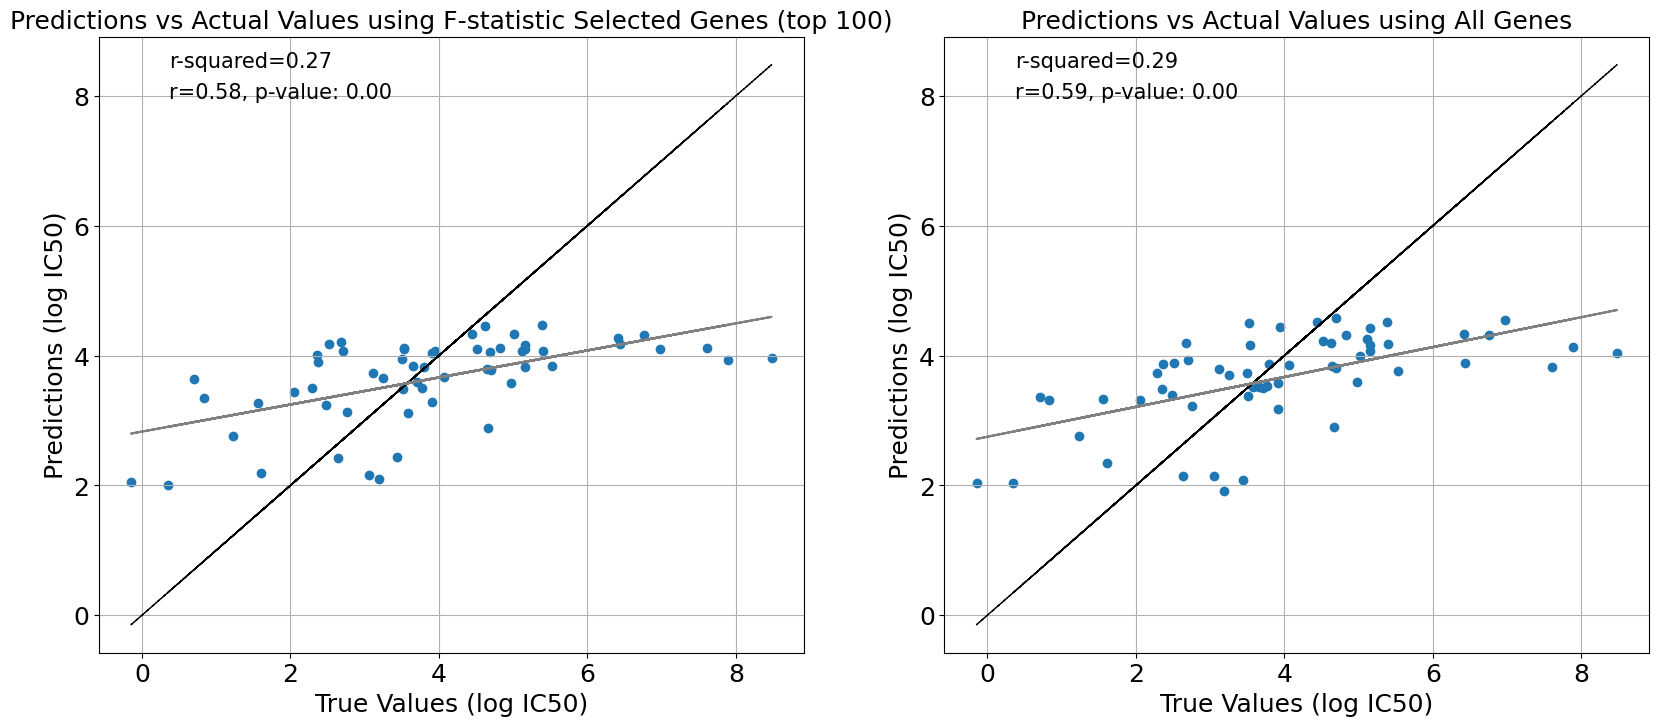

In [7]:
# split the data into train and test set

from sklearn.model_selection import train_test_split

# using f-regression to select the top n features 

from sklearn.feature_selection import SelectKBest, f_regression

# import lasso regression model

from sklearn.linear_model import ElasticNet

# import neural network model

from sklearn.neural_network import MLPRegressor

# import xgboost model

from xgboost import XGBRegressor

import numpy as np

X_train, X_test, y_train, y_test = train_test_split(feature_data, label_data, test_size=0.1, 
                                                    random_state=np.random.randint(1000))

# perform feature selection on the training set

selector = SelectKBest(f_regression, k=100)
selector.fit(X_train, y_train)

# get the selected features

selected_features = X_train.columns[selector.get_support()]

# train the model on the selected features

model = ElasticNet()
model.fit(X_train[selected_features], y_train)

lasso_all_features = ElasticNet()
lasso_all_features.fit(X_train, y_train)

# get the predictions

y_pred = model.predict(X_test[selected_features])
predictions_all_features = lasso_all_features.predict(X_test)

# get the score

from sklearn.metrics import mean_squared_error

score = mean_squared_error(y_test, y_pred)
score_all = mean_squared_error(y_test, predictions_all_features)

print(f'score using selected features: {score:.4f}, score using all features: {score_all:.4f}')

# plot the predictions vs the actual values

import matplotlib.pyplot as plt
import Visualisation as vis

# make a 1x2 subplots
fig, ax = plt.subplots(1, 2, figsize=(20,8))

# for each axis, plot the predictions vs the actual values
vis.plot_predictions_vs_actual_values(y_test, y_pred, ax=ax[0], 
                                      title='Predictions vs Actual Values using F-statistic Selected Genes (top 100)',
                                      x_label='True Values (log IC50)', y_label='Predictions (log IC50)',
                                      minitext_size=15)
vis.plot_predictions_vs_actual_values(y_test, predictions_all_features, ax=ax[1], 
                                      title='Predictions vs Actual Values using All Genes',
                                      x_label='True Values (log IC50)', y_label='Predictions (log IC50)',
                                      minitext_size=15)

# show the plot
plt.show()


#### Bulk run

In [8]:
# iterate feature selection for {repeat} times 
from sklearn.metrics import r2_score
from scipy.stats import pearsonr

# import elastic net regression model and random forest regression model

from sklearn.linear_model import ElasticNet
from sklearn.ensemble import RandomForestRegressor

run_code_block = True

if run_code_block:

    repeats = 100
    test_size = 0.1
    exp_ids = ['ANOVA 10 Genes', 'ANOVA 100 Genes', 'ANOVA 1000 Genes', 'All Genes']
    feature_selection_size = [10, 100, 1000, feature_data.shape[1]]

    data = []
    data_column_names = ['exp_id', 'random_seed', 'score', 'y_pred', 'y_test', 'selected_features', 'pearson_corr', 'pearson_p_val', 'r_squared']

    for i in range(repeats):
        random_seed = np.random.randint(1000)
        X_train, X_test, y_train, y_test = train_test_split(feature_data, label_data, test_size=test_size, 
                                                            random_state=random_seed)

        for exp_id, k in zip(exp_ids, feature_selection_size):
            selector = SelectKBest(f_regression, k=k)
            selector.fit(X_train, y_train)
            selected_features = X_train.columns[selector.get_support()].tolist()
            model = ElasticNet()
            model.fit(X_train[selected_features], y_train)
            y_pred = model.predict(X_test[selected_features])
            score = mean_squared_error(y_test, y_pred)
            corr, p_val = pearsonr(y_test, y_pred)
            r_squared = r2_score(y_test, y_pred)

            # print debug info
            print(f'iteration: {i}, score: {score:.4f}, pearson corr: {corr:.4f}, pearson p_val: {p_val:.4f}, r_squared: {r_squared:.4f}')

            row = [exp_id, random_seed, score, y_pred, y_test.tolist(), selected_features, corr, p_val, r_squared]
            data.append(row)

    # save result in a dataframe
    collection_df_gene_freg = pd.DataFrame(data, columns=data_column_names)

    # save the dataframe to a pickle file
    with open('data/processed-results/elastic_net_freg_results_ccle_palbociclib.pkl', 'wb') as f:
        pickle.dump(collection_df_gene_freg, f)

iteration: 0, score: 2.0254, pearson corr: 0.5213, pearson p_val: 0.0000, r_squared: 0.2090
iteration: 0, score: 2.0140, pearson corr: 0.5221, pearson p_val: 0.0000, r_squared: 0.2134
iteration: 0, score: 1.8091, pearson corr: 0.6230, pearson p_val: 0.0000, r_squared: 0.2935
iteration: 0, score: 1.7975, pearson corr: 0.6236, pearson p_val: 0.0000, r_squared: 0.2980
iteration: 1, score: 1.4018, pearson corr: 0.5343, pearson p_val: 0.0000, r_squared: 0.2786
iteration: 1, score: 1.3466, pearson corr: 0.5630, pearson p_val: 0.0000, r_squared: 0.3070
iteration: 1, score: 1.3242, pearson corr: 0.5672, pearson p_val: 0.0000, r_squared: 0.3185
iteration: 1, score: 1.3003, pearson corr: 0.5786, pearson p_val: 0.0000, r_squared: 0.3308
iteration: 2, score: 1.5672, pearson corr: 0.4910, pearson p_val: 0.0001, r_squared: 0.2320
iteration: 2, score: 1.6477, pearson corr: 0.4518, pearson p_val: 0.0003, r_squared: 0.1926
iteration: 2, score: 1.6700, pearson corr: 0.4322, pearson p_val: 0.0006, r_squa

In [9]:
# std and mean of pearson correlation
print(f'pearson correlation mean: {collection_df_gene_freg["pearson_corr"].mean():.4f}, std: {collection_df_gene_freg["pearson_corr"].std():.4f}')

pearson correlation mean: 0.5805, std: 0.0960


In [10]:
# open from pickle 

with open('data/processed-results/elastic_net_freg_results_ccle_palbociclib.pkl', 'rb') as f:
    collection_df_gene_freg = pickle.load(f)

collection_df_gene_freg.head()

,exp_id,random_seed,score,y_pred,y_test,selected_features,pearson_corr,pearson_p_val,r_squared
0,ANOVA 10 Genes,324,2.025376,"[3.702860019611826, 3.3780317147461894, 4.3250...","[1.966539, 4.699566, 5.402921, 0.9205, 2.66765...","[WAS, RPL3, AMOTL2, NCKAP1L, SDC4, LAMA5, SLC4...",0.521309,2.300620e-05,0.208993
1,ANOVA 100 Genes,324,2.014049,"[3.646503982946904, 3.3740072409110855, 4.1144...","[1.966539, 4.699566, 5.402921, 0.9205, 2.66765...","[TSPAN6, ITGAL, ITGA3, TNFRSF12A, BAIAP2L1, TR...",0.522133,2.221362e-05,0.213417
2,ANOVA 1000 Genes,324,1.809093,"[3.29463583984293, 3.5994979573969985, 4.03668...","[1.966539, 4.699566, 5.402921, 0.9205, 2.66765...","[TSPAN6, FGR, FUCA2, CD38, TSPOAP1, ITGAL, ITG...",0.622964,1.372175e-07,0.293462
3,All Genes,324,1.797460,"[3.398922925913322, 3.620660273097462, 4.02524...","[1.966539, 4.699566, 5.402921, 0.9205, 2.66765...","[TSPAN6, TNMD, DPM1, SCYL3, C1orf112, FGR, CFH...",0.623638,1.318127e-07,0.298005
4,ANOVA 10 Genes,130,1.401791,"[3.9704172831218982, 3.6120977900782956, 3.271...","[4.076791, 3.772661, 2.458795, 3.635455, 5.497...","[WAS, RPL3, TJP1, AMOTL2, SDC4, LAMA5, SLC49A4...",0.534347,1.306322e-05,0.278603


#### Using Linear Regression

random state value: 7846


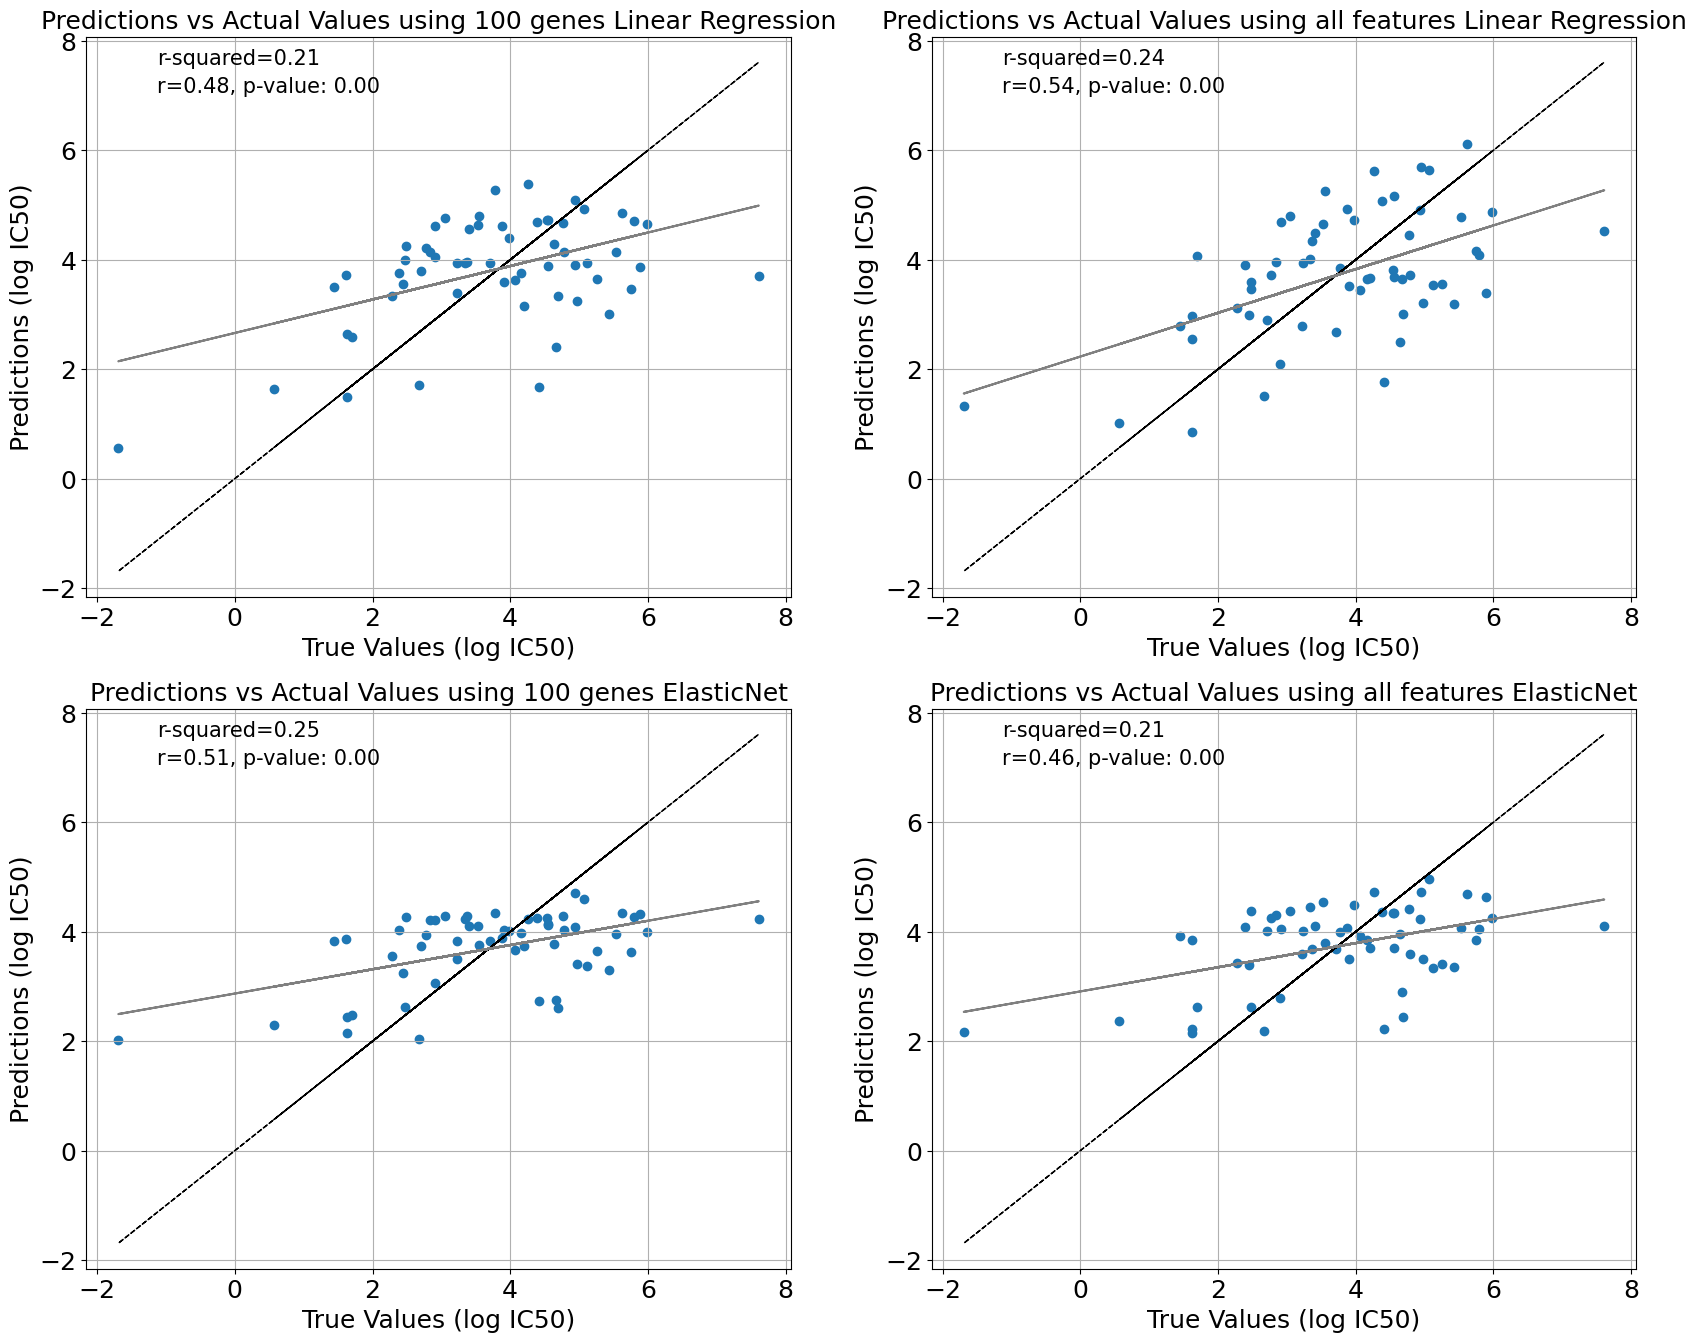

In [11]:
# split the data into train and test set

from sklearn.model_selection import train_test_split

# using f-regression to select the top n features 

from sklearn.feature_selection import SelectKBest, f_regression

# import lasso regression model

from sklearn.linear_model import ElasticNet, LinearRegression

# import neural network model

from sklearn.neural_network import MLPRegressor

# import xgboost model

from xgboost import XGBRegressor

import numpy as np

random_state_value = np.random.randint(10000)

print(f'random state value: {random_state_value}')

X_train, X_test, y_train, y_test = train_test_split(feature_data, label_data, test_size=0.1, 
                                                    random_state=random_state_value)

# perform feature selection on the training set

selector = SelectKBest(f_regression, k=100)
selector.fit(X_train, y_train)

# get the selected features

selected_features = X_train.columns[selector.get_support()]

# train the model on the selected features

model = LinearRegression()
model.fit(X_train[selected_features], y_train)

model_all_features = LinearRegression()
model_all_features.fit(X_train, y_train)

default_model = ElasticNet()
default_model.fit(X_train[selected_features], y_train)

default_model_all_features = ElasticNet()
default_model_all_features.fit(X_train, y_train)

# get the predictions

y_pred = model.predict(X_test[selected_features])
predictions_all_features = model_all_features.predict(X_test)

predictions_default = default_model.predict(X_test[selected_features])
predictions_all_features_default = default_model_all_features.predict(X_test)

# plot the predictions vs the actual values

import matplotlib.pyplot as plt
import Visualisation as vis

all_predictions = [y_pred, predictions_all_features, predictions_default, predictions_all_features_default]
model_names = ['100 genes Linear Regression', 'all features Linear Regression', '100 genes ElasticNet', 'all features ElasticNet']

# make a 1x2 subplots
fig, axes = plt.subplots(2, 2, figsize=(20,16))

# for each axis, plot the predictions vs the actual values, use ax.flatten 
# to flatten the 2x2 array into a 1D array
for i, ax in enumerate(axes.flatten()):
    vis.plot_predictions_vs_actual_values(y_test, all_predictions[i], ax=ax, 
                                          title=f'Predictions vs Actual Values using {model_names[i]}',
                                          x_label='True Values (log IC50)', y_label='Predictions (log IC50)',
                                          minitext_size=15)

# plt.title('Predictions vs Actual Values using ElasticNet (fine-tuned and default)')
# show the plot
plt.show()


#### Bulk run (LR)

In [12]:
# iterate feature selection for {repeat} times 
from sklearn.metrics import r2_score
from scipy.stats import pearsonr

# import elastic net regression model and random forest regression model

from sklearn.linear_model import ElasticNet
from sklearn.ensemble import RandomForestRegressor

run_code_block = False

if run_code_block:

    repeats = 100
    test_size = 0.1
    exp_ids = ['ANOVA 10 Genes (LR)', 'ANOVA 100 Genes (LR)', 'ANOVA 1000 Genes (LR)', 'All Genes (LR)']
    feature_selection_size = [10, 100, 1000, feature_data.shape[1]]

    data = []
    data_column_names = ['exp_id', 'random_seed', 'score', 'y_pred', 'y_test', 'selected_features', 'pearson_corr', 'pearson_p_val', 'r_squared']

    for i in range(repeats):
        random_seed = np.random.randint(1000)
        X_train, X_test, y_train, y_test = train_test_split(feature_data, label_data, test_size=test_size, 
                                                            random_state=random_seed)

        for exp_id, k in zip(exp_ids, feature_selection_size):
            selector = SelectKBest(f_regression, k=k)
            selector.fit(X_train, y_train)
            selected_features = X_train.columns[selector.get_support()].tolist()
            if exp_id == 'All Genes':
                selected_features = X_train.columns.tolist()
            model = ElasticNet()
            model.fit(X_train[selected_features], y_train)
            y_pred = model.predict(X_test[selected_features])
            score = mean_squared_error(y_test, y_pred)
            corr, p_val = pearsonr(y_test, y_pred)
            r_squared = r2_score(y_test, y_pred)

            # print debug info
            print(f'iteration: {i}, exp-id: {exp_id}, score: {score:.2f}, pearson corr: {corr:.2f}, pearson p_val: {p_val:.2f}, r_squared: {r_squared:.2f}')

            row = [exp_id, random_seed, score, y_pred, y_test.tolist(), selected_features, corr, p_val, r_squared]
            data.append(row)

    # save result in a dataframe
    collection_df_gene_fine_tune = pd.DataFrame(data, columns=data_column_names)

    # save the dataframe to a pickle file
    with open('data/processed-results/elastic_net_fine_tune_results_ccle_palbociclib.pkl', 'wb') as f:
        pickle.dump(collection_df_gene_fine_tune, f)

#### Visualising performance with selecting genes vs whole genome

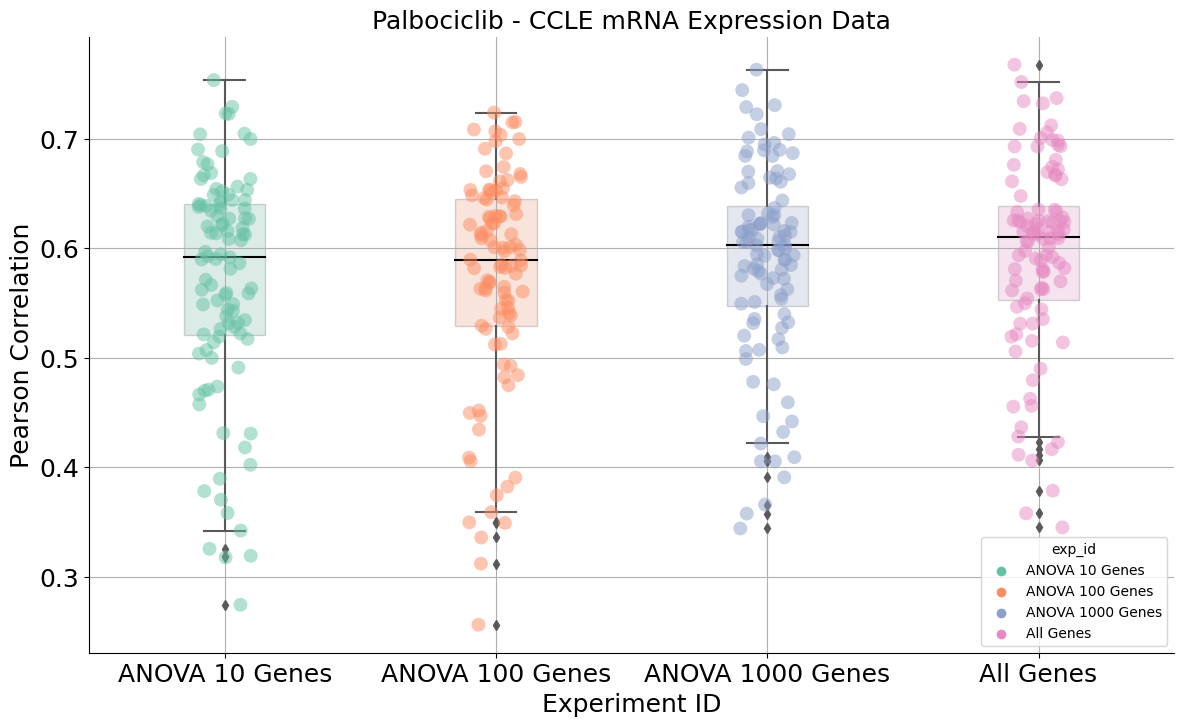

In [13]:
# plot collection df as a boxplot

import seaborn as sns
import matplotlib.pyplot as plt

import Visualisation as vis

fig, ax = plt.subplots(figsize=(14,8))
    
vis.plot_box_plot(collection_df_gene_freg, 'exp_id', 'pearson_corr', 'Palbociclib - CCLE mRNA Expression Data',
                'Experiment ID', 'Pearson Correlation', ax=ax)


plt.grid()
sns.despine()
# show the plot
plt.show()


This concludes that f-regression simply cannot outperform training using all features. 

In [14]:
# using STRING database to select the 1st,2nd and 3rd degree neighbours of the drug target

## Feature Selection using proteomic expression data from Goncalves et al.

In [15]:
import pandas as pd
import pickle

# import GDSC2 drug response data using pickle

with open('data/drug-response/GDSC2/cache_gdsc2.pkl', 'rb') as f:
    gdsc2 = pickle.load(f)
    gdsc2_info = pickle.load(f)

# import proteomic expression 
with open('data/proteomic-expression/goncalves-2022-cell/goncalve_proteome_fillna_processed.pkl', 'rb') as f:
    joined_full_protein_matrix = pickle.load(f)
    joined_sin_peptile_exclusion_matrix = pickle.load(f)

# import STRING database using pickle

with open('data/protein-interaction/STRING/string_df.pkl', 'rb') as f:
    string_df = pickle.load(f)
    string_df_info = pickle.load(f)
    string_df_alias = pickle.load(f)

# open STRING to goncalves mapping file

with open('data\protein-interaction\STRING\goncalve_to_string_id_df.pkl', 'rb') as f:
    goncalve_to_string_id_df = pickle.load(f)




In [16]:
import DataFunctions as utils 

# create the full dataset

palbociclib_proteomic_df = utils.create_joint_dataset_from_proteome_gdsc('Palbociclib', 
                                                                         joined_sin_peptile_exclusion_matrix, gdsc2)

In [17]:
feature_data, label_data = utils.create_feature_and_label(palbociclib_proteomic_df)

In [18]:
feature_data.head()

,P37108;SRP14_HUMAN,Q96JP5;ZFP91_HUMAN,Q9Y4H2;IRS2_HUMAN,P36578;RL4_HUMAN,Q6SPF0;SAMD1_HUMAN,O76031;CLPX_HUMAN,Q8WUQ7;CATIN_HUMAN,A6NIH7;U119B_HUMAN,Q9BTD8;RBM42_HUMAN,Q9P258;RCC2_HUMAN,...,P33151;CADH5_HUMAN,Q5EBL4;RIPL1_HUMAN,P49715;CEBPA_HUMAN,Q5TA45;INT11_HUMAN,O14924;RGS12_HUMAN,Q7Z3B1;NEGR1_HUMAN,O60669;MOT2_HUMAN,Q13571;LAPM5_HUMAN,Q96JM2;ZN462_HUMAN,P35558;PCKGC_HUMAN
SIDM00042,5.70786,0.00000,0.0000,6.22574,0.00000,4.49579,0.0,0.00000,2.87981,0.00000,...,0.0,0.0000,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0
SIDM00044,6.04591,3.69356,0.0000,7.07092,3.49594,4.05438,0.0,0.00000,3.44202,4.34237,...,0.0,3.0226,0.0,0.0,0.0,0.0,2.16952,0.0,0.0,0.0
SIDM00045,6.20582,2.88118,0.0000,8.25336,3.35439,5.09923,0.0,0.00000,3.56256,6.01081,...,0.0,0.0000,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0
SIDM00047,6.80469,2.78737,0.0000,7.58653,2.14980,5.43356,0.0,3.50808,3.43601,5.12233,...,0.0,0.0000,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0
SIDM00049,6.28591,0.00000,2.1142,6.98525,3.52912,4.74122,0.0,0.00000,3.51710,5.81359,...,0.0,0.0000,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0


In [19]:
label_data.head()

SIDM00042    5.344381
SIDM00044    2.482390
SIDM00045    0.057768
SIDM00047    2.949412
SIDM00049    3.275468
Name: LN_IC50, dtype: float64

### Selection using f-regression

score using selected features: 1.4262, score using all features: 1.3681


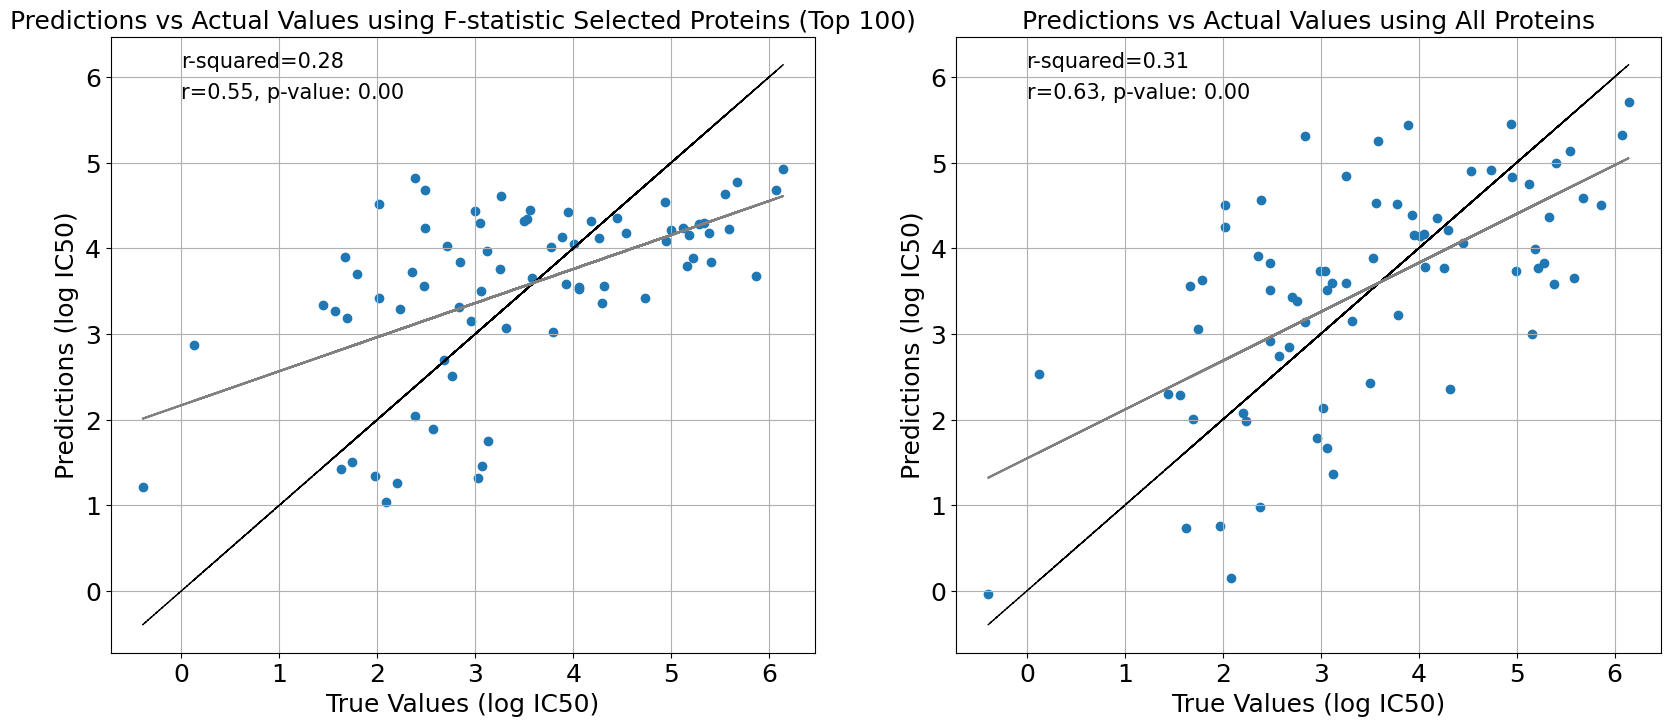

In [20]:
# split the data into train and test set

from sklearn.model_selection import train_test_split

# import lasso regression model

from sklearn.linear_model import ElasticNet, ElasticNetCV

# import feature selection

from sklearn.feature_selection import SelectKBest, f_regression


import numpy as np

X_train, X_test, y_train, y_test = train_test_split(feature_data, label_data, test_size=0.1, 
                                                    random_state=np.random.randint(1000))

# perform feature selection on the training set

selector = SelectKBest(f_regression, k=100)
selector.fit(X_train, y_train)

# get the selected features

selected_features = X_train.columns[selector.get_support()]

# train the model on the selected features

lasso = ElasticNet(alpha=0.1)
lasso.fit(X_train[selected_features], y_train)

lasso_all_features = ElasticNet(alpha=0.1)
lasso_all_features.fit(X_train, y_train)

# get the predictions

y_pred = lasso.predict(X_test[selected_features])
predictions_all_features = lasso_all_features.predict(X_test)

# get the score

from sklearn.metrics import mean_squared_error

score = mean_squared_error(y_test, y_pred)
score_all = mean_squared_error(y_test, predictions_all_features)

print(f'score using selected features: {score:.4f}, score using all features: {score_all:.4f}')

# plot the predictions vs the actual values

import matplotlib.pyplot as plt
import Visualisation as vis

# make a 1x2 subplots
fig, ax = plt.subplots(1, 2, figsize=(20,8))

# for each axis, plot the predictions vs the actual values
vis.plot_predictions_vs_actual_values(y_test, y_pred, ax=ax[0], 
                                      title='Predictions vs Actual Values using F-statistic Selected Proteins (Top 100)',
                                      x_label='True Values (log IC50)', y_label='Predictions (log IC50)',
                                      minitext_size=15)
vis.plot_predictions_vs_actual_values(y_test, predictions_all_features, ax=ax[1], 
                                      title='Predictions vs Actual Values using All Proteins',
                                      x_label='True Values (log IC50)', y_label='Predictions (log IC50)',
                                      minitext_size=15)
# show the plot
plt.show()


#### Bulk run

In [21]:
# iterate feature selection for {repeat} times 
from sklearn.metrics import r2_score
from scipy.stats import pearsonr

# import elastic net regression model and random forest regression model

from sklearn.linear_model import ElasticNet
from sklearn.ensemble import RandomForestRegressor

repeats = 100
test_size = 0.1
exp_ids = ['ANOVA Proteins 10', 'ANOVA Proteins 100', 'ANOVA Proteins 1000', 'All Proteins']
feature_selection_size = [10, 100, 1000, feature_data.shape[1]]

data = []
data_column_names = ['exp_id', 'random_seed', 'score', 'y_pred', 'y_test', 'selected_features', 'pearson_corr', 'pearson_p_val', 'r_squared']

for i in range(repeats):
    random_seed = np.random.randint(1000)
    X_train, X_test, y_train, y_test = train_test_split(feature_data, label_data, test_size=test_size, 
                                                        random_state=random_seed)

    for exp_id, k in zip(exp_ids, feature_selection_size):
        selector = SelectKBest(f_regression, k=k)
        selector.fit(X_train, y_train)
        selected_features = X_train.columns[selector.get_support()].tolist()
        model = ElasticNet()
        model.fit(X_train[selected_features], y_train)
        y_pred = model.predict(X_test[selected_features])
        score = mean_squared_error(y_test, y_pred)
        corr, p_val = pearsonr(y_test, y_pred)
        r_squared = r2_score(y_test, y_pred)

        # print debug info
        print(f'iteration: {i}, score: {score:.4f}, pearson corr: {corr:.4f}, pearson p_val: {p_val:.4f}, r_squared: {r_squared:.4f}')

        row = [exp_id, random_seed, score, y_pred, y_test.tolist(), selected_features, corr, p_val, r_squared]
        data.append(row)

# save result in a dataframe
collection_df_freg_proteome = pd.DataFrame(data, columns=data_column_names)



iteration: 0, score: 1.7863, pearson corr: 0.5279, pearson p_val: 0.0000, r_squared: 0.2550
iteration: 0, score: 1.7061, pearson corr: 0.5500, pearson p_val: 0.0000, r_squared: 0.2884
iteration: 0, score: 1.6392, pearson corr: 0.5753, pearson p_val: 0.0000, r_squared: 0.3163
iteration: 0, score: 1.5700, pearson corr: 0.6073, pearson p_val: 0.0000, r_squared: 0.3452
iteration: 1, score: 1.5679, pearson corr: 0.6249, pearson p_val: 0.0000, r_squared: 0.3381
iteration: 1, score: 1.4035, pearson corr: 0.6744, pearson p_val: 0.0000, r_squared: 0.4075
iteration: 1, score: 1.2641, pearson corr: 0.7277, pearson p_val: 0.0000, r_squared: 0.4664
iteration: 1, score: 1.2206, pearson corr: 0.7403, pearson p_val: 0.0000, r_squared: 0.4847
iteration: 2, score: 2.3636, pearson corr: 0.3498, pearson p_val: 0.0023, r_squared: 0.1029
iteration: 2, score: 2.2018, pearson corr: 0.4253, pearson p_val: 0.0002, r_squared: 0.1643
iteration: 2, score: 2.0562, pearson corr: 0.5006, pearson p_val: 0.0000, r_squa

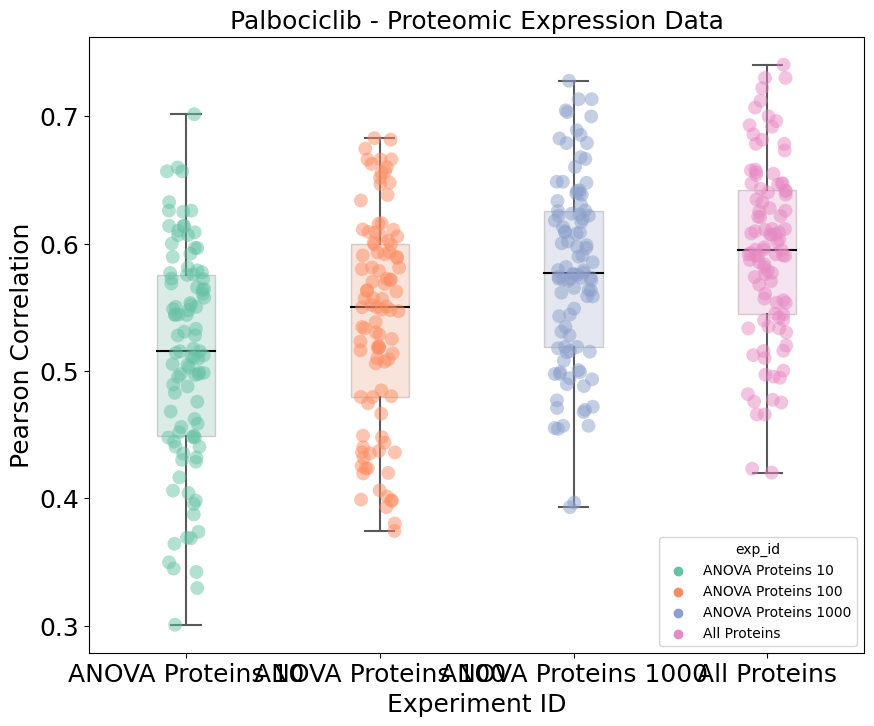

In [22]:
# plot collection df as a boxplot

import seaborn as sns
import matplotlib.pyplot as plt

import Visualisation as vis

fig, ax = plt.subplots(figsize=(10,8))
    
vis.plot_box_plot(collection_df_freg_proteome, 'exp_id', 'pearson_corr', 'Palbociclib - Proteomic Expression Data',
                'Experiment ID', 'Pearson Correlation', ax=ax)

# show the plot
plt.show()


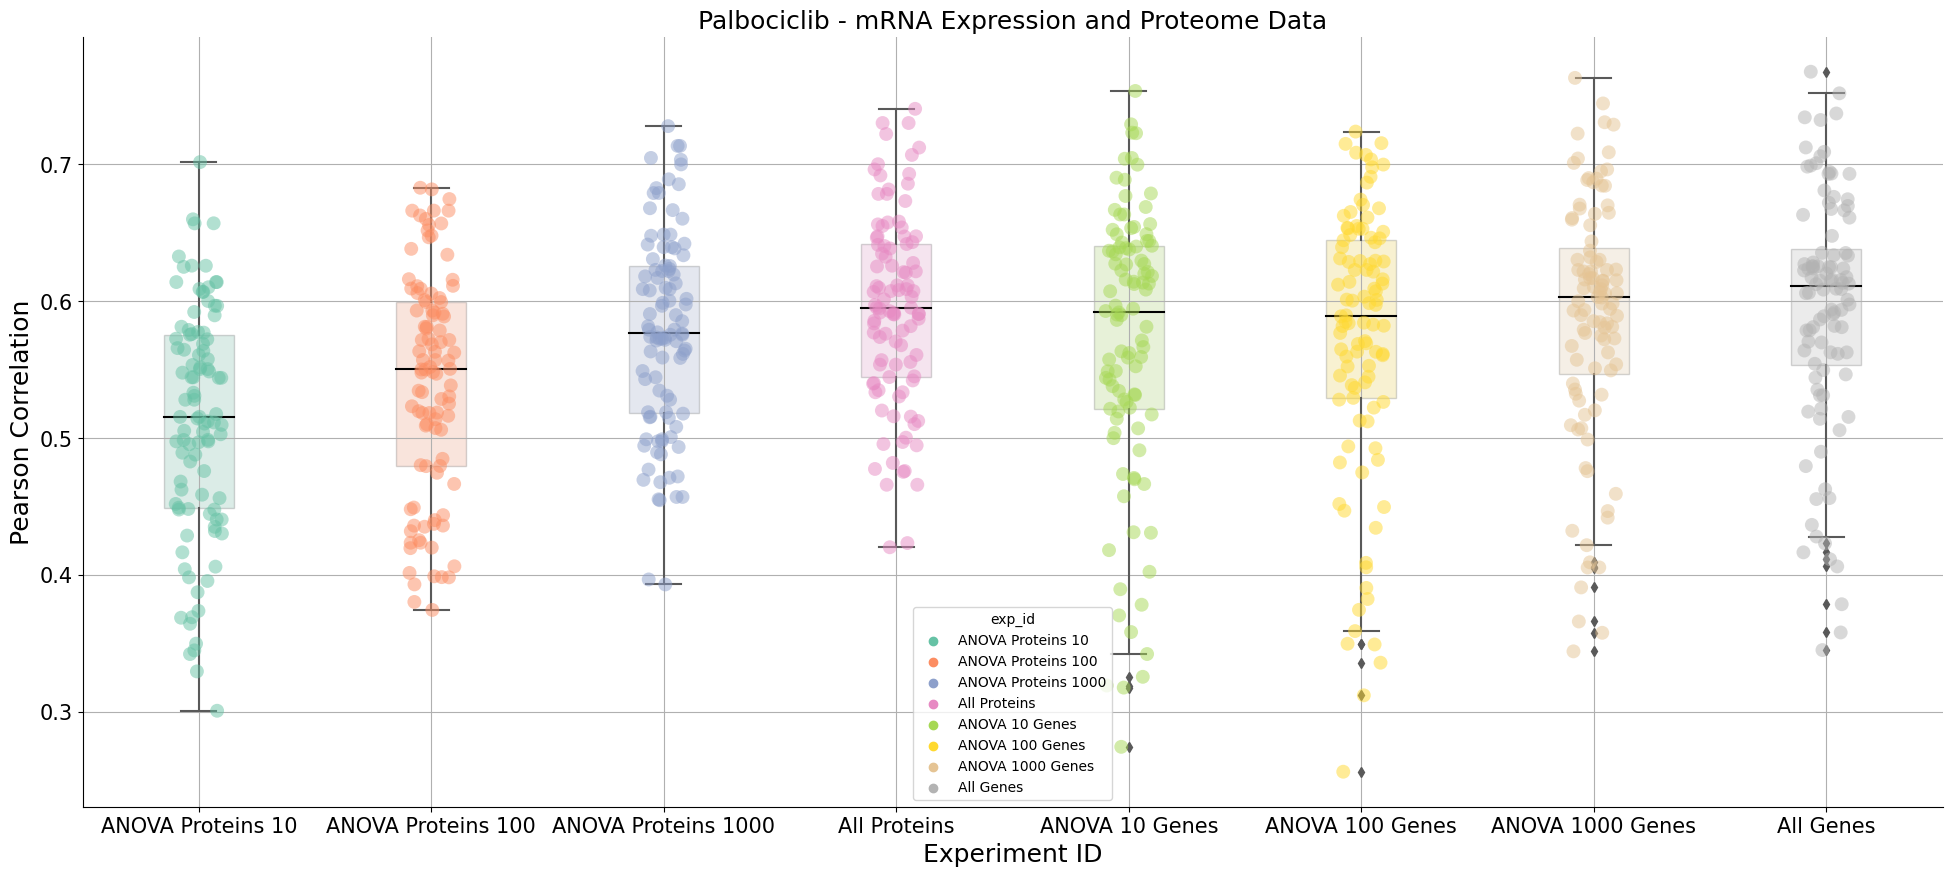

In [23]:
# combine the results from the two datasets

collection_df_freg_all = pd.concat([collection_df_freg_proteome, collection_df_gene_freg], ignore_index=True)

# plot collection df as a boxplot

fig, ax = plt.subplots(figsize=(24,10))

vis.plot_box_plot(collection_df_freg_all, 'exp_id', 'pearson_corr', 'Palbociclib - mRNA Expression and Proteome Data',
                'Experiment ID', 'Pearson Correlation', ax=ax, tick_fontsize=15)          

sns.despine()
plt.grid()
# show the plot
plt.show()

### Selection using STRING

#### Generating Interaction Partners

In [24]:
# using STRING database to select the 1st,2nd and 3rd degree neighbours of the drug target
import pickle 
import pandas as pd

with open('data/protein-interaction/STRING/palbociclib_nth_degree_neighbours.pkl', 'rb') as f:
    nth_degree_neighbours = pickle.load(f)

drug_targets = nth_degree_neighbours[0]
first_degree_neighbours = nth_degree_neighbours[1]
second_degree_neighbours = nth_degree_neighbours[2]
third_degree_neighbours = nth_degree_neighbours[3]

In [25]:
# select features from the first degree neighbours

feature_data_first_degree = feature_data[first_degree_neighbours]

feature_data_first_degree.head()

,P50750;CDK9_HUMAN,Q14186;TFDP1_HUMAN,P04637;P53_HUMAN,P51946;CCNH_HUMAN,P50613;CDK7_HUMAN,O95067;CCNB2_HUMAN,P20248;CCNA2_HUMAN,Q13309;SKP2_HUMAN,P16989;YBOX3_HUMAN,O75832;PSD10_HUMAN,...,Q9P2W1;HOP2_HUMAN,P51948;MAT1_HUMAN,P12931;SRC_HUMAN,P07900;HS90A_HUMAN,P12004;PCNA_HUMAN,P42771;CDN2A_HUMAN,P24385;CCND1_HUMAN,P07948;LYN_HUMAN,P31947;1433S_HUMAN,P49918;CDN1C_HUMAN
SIDM00042,0.00000,0.0,0.00000,0.0,0.0,0.0,0.00000,0.0,2.56338,0.00000,...,0.0,0.00000,0.00000,5.77254,5.02710,0.0,0.0,0.00000,7.33660,0.0
SIDM00044,0.00000,0.0,0.00000,0.0,0.0,0.0,0.00000,0.0,4.23056,2.76831,...,0.0,0.00000,0.00000,9.78612,7.77206,0.0,0.0,3.14498,9.81594,0.0
SIDM00045,2.54225,0.0,3.68677,0.0,0.0,0.0,2.67813,0.0,5.07592,2.57275,...,0.0,1.36169,2.75757,9.73268,8.05159,0.0,0.0,2.52465,9.62882,0.0
SIDM00047,2.08931,0.0,0.00000,0.0,0.0,0.0,0.00000,0.0,5.09561,0.00000,...,0.0,0.00000,2.20435,8.56821,7.31040,0.0,0.0,3.50726,9.74553,0.0
SIDM00049,0.00000,0.0,1.85910,0.0,0.0,0.0,0.00000,0.0,3.37366,0.00000,...,0.0,0.00000,2.69990,9.63436,8.30676,0.0,0.0,3.05039,10.61189,0.0


score using selected features: 2.4621


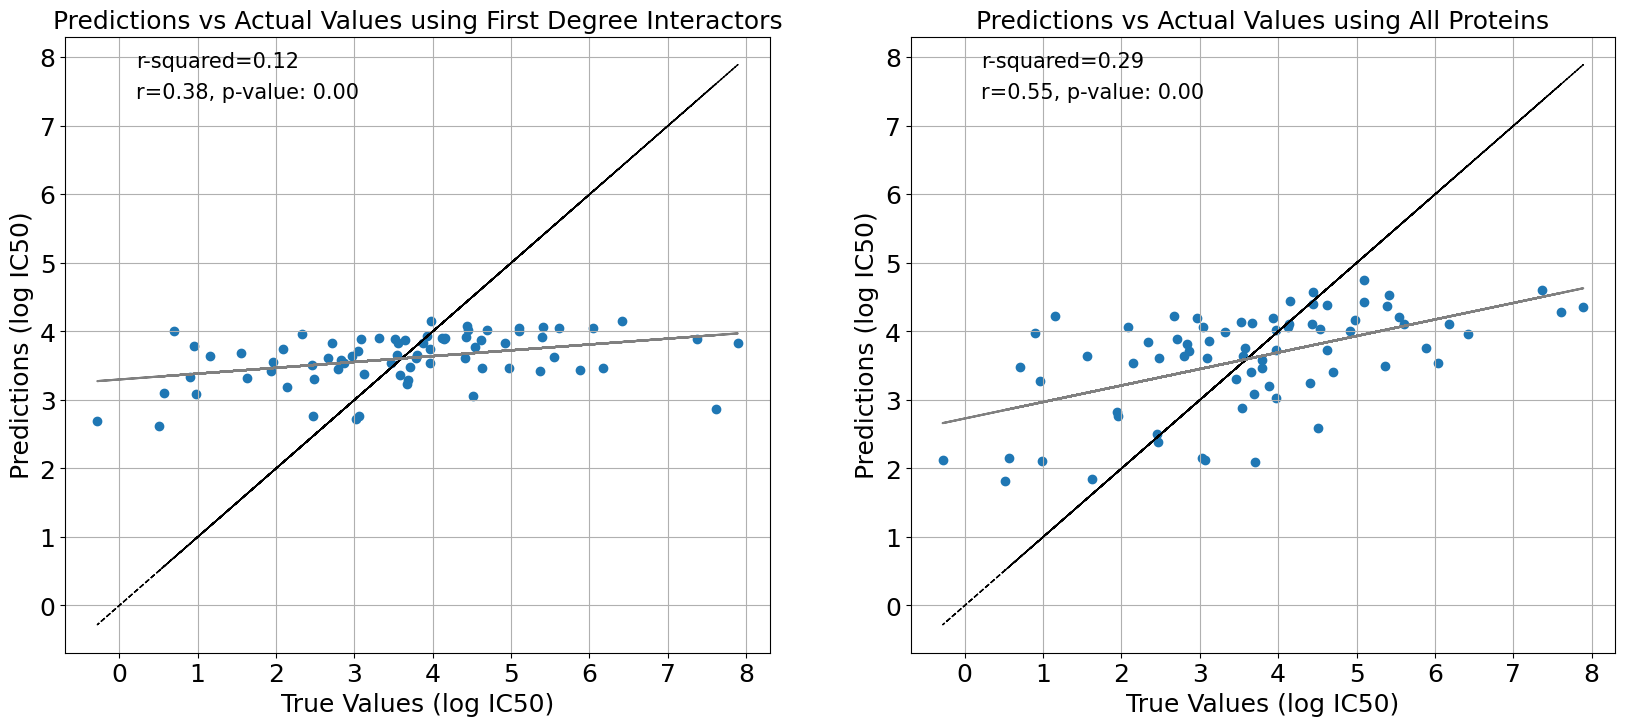

In [26]:
# split the data into train and test set

from sklearn.model_selection import train_test_split

# import lasso regression model

from sklearn.linear_model import ElasticNet

import numpy as np

X_train, X_test, y_train, y_test = train_test_split(feature_data, label_data, test_size=0.1,
                                                    random_state=np.random.randint(1000))

# train the model 

# perform feature selection on the training set, using n degree interactors

n_degree_neighbours = first_degree_neighbours 

X_train_first_degree = X_train[n_degree_neighbours]

# train the model on the selected features

lasso = ElasticNet()
lasso.fit(X_train_first_degree, y_train)

lasso_all_features = ElasticNet()
lasso_all_features.fit(X_train, y_train)



# get the predictions

y_pred = lasso.predict(X_test[n_degree_neighbours])
predictions_all_features = lasso_all_features.predict(X_test)

# get the score

from sklearn.metrics import mean_squared_error

score = mean_squared_error(y_test, y_pred)

print(f'score using selected features: {score:.4f}')

# plot the predictions vs the actual values

import matplotlib.pyplot as plt
import Visualisation as vis

# make a 1x2 subplots
fig, ax = plt.subplots(1, 2, figsize=(20,8))

# for each axis, plot the predictions vs the actual values
vis.plot_predictions_vs_actual_values(y_test, y_pred, ax=ax[0],
                                        title='Predictions vs Actual Values using First Degree Interactors',
                                        x_label='True Values (log IC50)', y_label='Predictions (log IC50)',
                                        minitext_size=15)
vis.plot_predictions_vs_actual_values(y_test, predictions_all_features, ax=ax[1],
                                        title='Predictions vs Actual Values using All Proteins',            
                                        x_label='True Values (log IC50)', y_label='Predictions (log IC50)',
                                        minitext_size=15)

# show the plot
plt.show()

#### Bulk run

In [27]:
# iterate feature selection for {repeat} times
from sklearn.metrics import r2_score
from scipy.stats import pearsonr

# import elastic net regression model and random forest regression model

from sklearn.linear_model import ElasticNet
from sklearn.ensemble import RandomForestRegressor

run_code_block = True

if run_code_block:

    repeats = 100
    test_size = 0.1
    exp_ids = ['First Degree', 'Second Degree', 'Third Degree']
    interactor_degrees = [first_degree_neighbours, second_degree_neighbours, third_degree_neighbours]

    data = []
    data_column_names = ['exp_id', 'random_seed', 'score', 'y_pred', 'y_test',
                         'selected_features', 'pearson_corr', 'pearson_p_val', 'r_squared']

    for i in range(repeats):
        random_seed = np.random.randint(1000)
        X_train, X_test, y_train, y_test = train_test_split(feature_data, label_data, test_size=test_size,
                                                            random_state=random_seed)

        for exp_id, n_degree_neighbours in zip(exp_ids, interactor_degrees):

            model = ElasticNet()
            model.fit(X_train[n_degree_neighbours], y_train)
            y_pred = model.predict(X_test[n_degree_neighbours])
            score = mean_squared_error(y_test, y_pred)
            corr, p_val = pearsonr(y_test, y_pred)
            r_squared = r2_score(y_test, y_pred)

            # print debug info
            print(
                f'iteration: {i}, score: {score:.4f}, pearson corr: {corr:.4f}, pearson p_val: {p_val:.4f}, r_squared: {r_squared:.4f}')

            row = [exp_id, random_seed, score, y_pred,
                   y_test.tolist(), n_degree_neighbours, corr, p_val, r_squared]
            data.append(row)

    # save result in a dataframe
    collection_df_string = pd.DataFrame(data, columns=data_column_names)

    # save the dataframe to a pickle file
    with open('data/processed-results/elastic_net_string_results_proteome_palbociclib.pkl', 'wb') as f:
        pickle.dump(collection_df_string, f)


iteration: 0, score: 2.0854, pearson corr: 0.4022, pearson p_val: 0.0004, r_squared: 0.1353
iteration: 0, score: 1.7407, pearson corr: 0.5475, pearson p_val: 0.0000, r_squared: 0.2783
iteration: 0, score: 1.7025, pearson corr: 0.5626, pearson p_val: 0.0000, r_squared: 0.2941
iteration: 1, score: 2.0026, pearson corr: 0.3725, pearson p_val: 0.0011, r_squared: 0.1260
iteration: 1, score: 1.6863, pearson corr: 0.5161, pearson p_val: 0.0000, r_squared: 0.2641
iteration: 1, score: 1.6082, pearson corr: 0.5478, pearson p_val: 0.0000, r_squared: 0.2981
iteration: 2, score: 2.1022, pearson corr: 0.5316, pearson p_val: 0.0000, r_squared: 0.1781
iteration: 2, score: 1.7417, pearson corr: 0.6043, pearson p_val: 0.0000, r_squared: 0.3190
iteration: 2, score: 1.7283, pearson corr: 0.5864, pearson p_val: 0.0000, r_squared: 0.3243
iteration: 3, score: 2.8015, pearson corr: 0.5077, pearson p_val: 0.0000, r_squared: 0.1569
iteration: 3, score: 2.3799, pearson corr: 0.5954, pearson p_val: 0.0000, r_squa

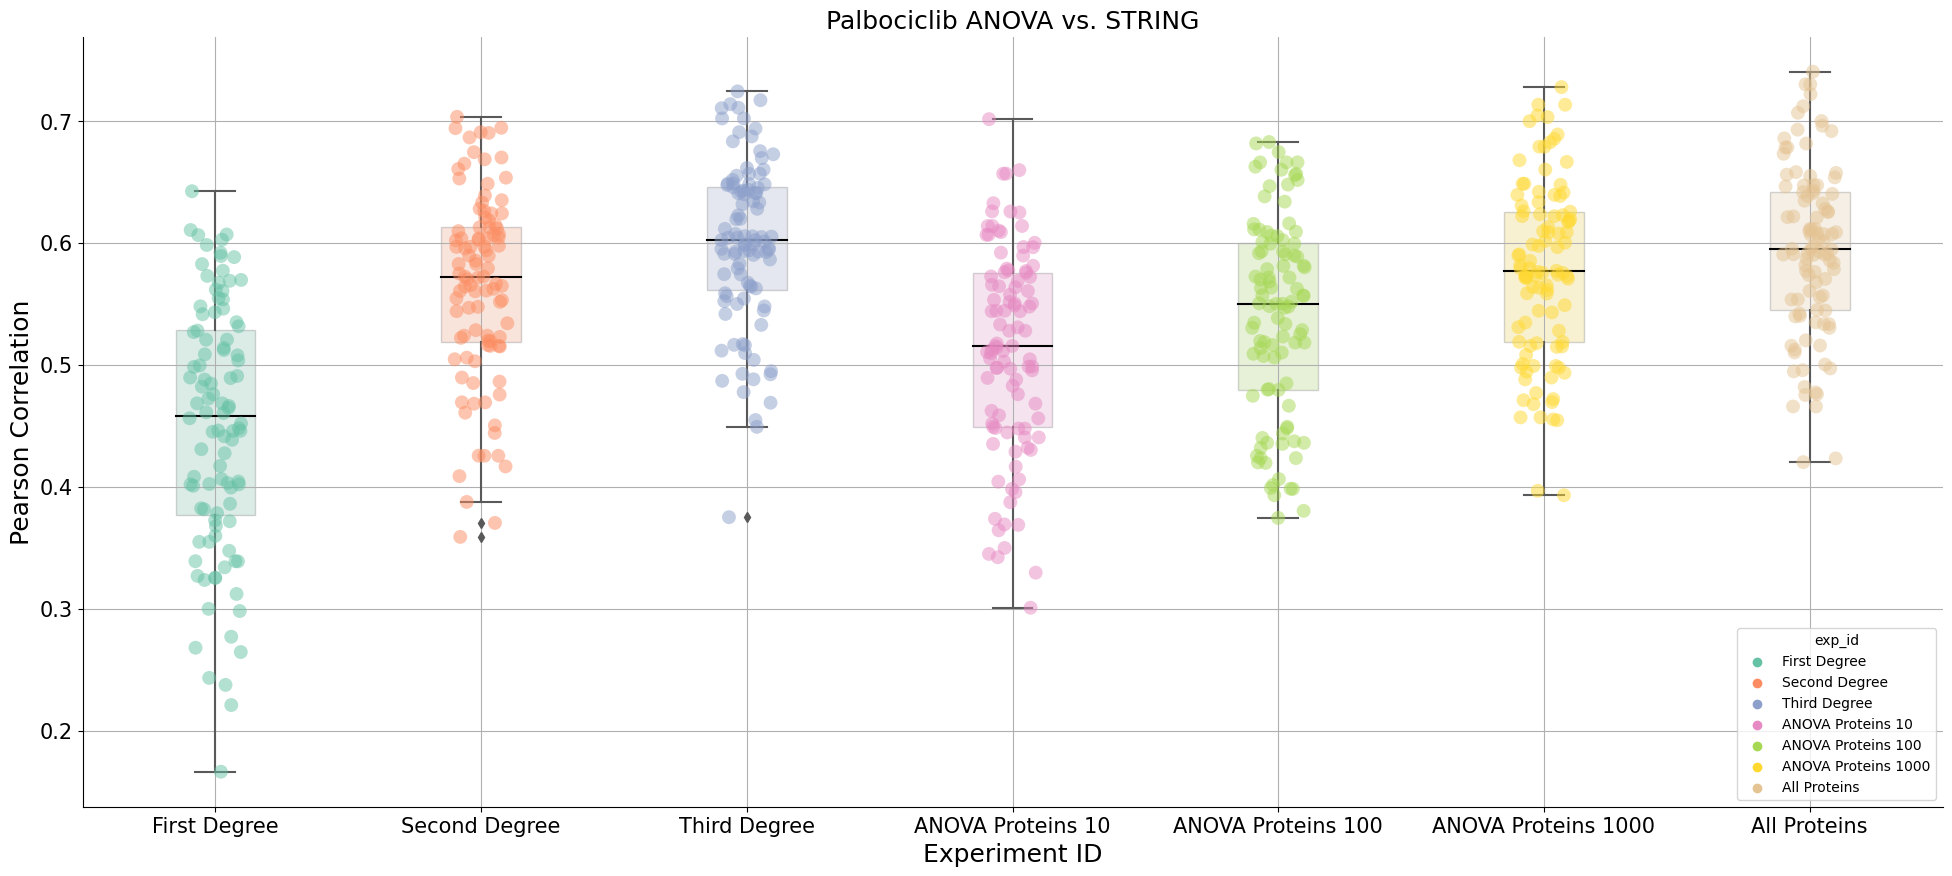

In [28]:
# combine the results from the two datasets

collection_df_proteome_interaction = pd.concat([collection_df_string, collection_df_freg_proteome], ignore_index=True)

# plot collection df as a boxplot

fig, ax = plt.subplots(figsize=(24,10))

vis.plot_box_plot(collection_df_proteome_interaction, 'exp_id', 'pearson_corr', 'Palbociclib ANOVA vs. STRING',
                'Experiment ID', 'Pearson Correlation', ax=ax, tick_fontsize=15)          

sns.despine()
plt.grid()
# show the plot
plt.show()

### Selection using random protein sets

score using selected features: 1.6314, score using all features: 1.5852


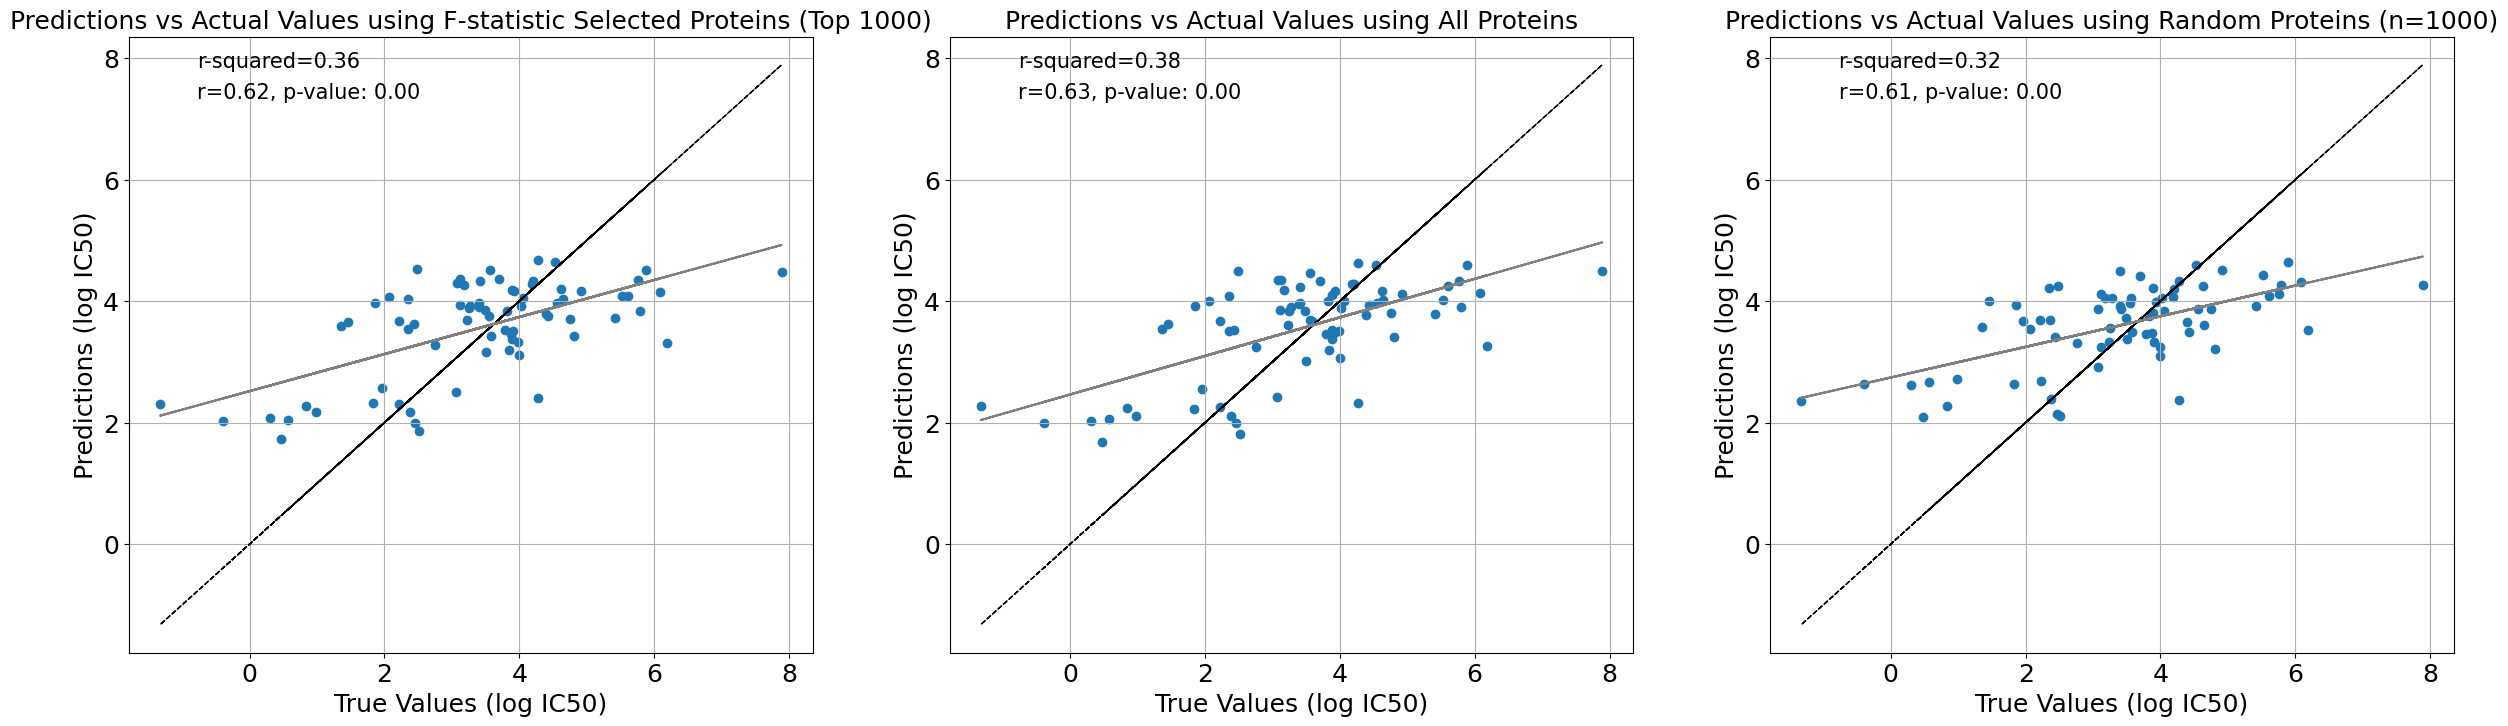

In [29]:
# split the data into train and test set

import Visualisation as vis
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

# import lasso regression model

from sklearn.linear_model import ElasticNet, ElasticNetCV

# import xgboost model

from xgboost import XGBRegressor

# import feature selection

from sklearn.feature_selection import SelectKBest, f_regression


import numpy as np

X_train, X_test, y_train, y_test = train_test_split(feature_data, label_data, test_size=0.1,
                                                    random_state=np.random.randint(1000))

# perform feature selection on the training set

n = 1000

selector = SelectKBest(f_regression, k=n)
selector.fit(X_train, y_train)

# get the selected features

selected_features = X_train.columns[selector.get_support()]
random_features = X_train.columns[np.random.choice(X_train.shape[1], n, replace=False)]

# train the model on the selected features

lasso = ElasticNet()
lasso.fit(X_train[selected_features], y_train)

lasso_all_features = ElasticNet()
lasso_all_features.fit(X_train, y_train)

model_random = ElasticNet()
model_random.fit(X_train[random_features], y_train)

# get the predictions

y_pred = lasso.predict(X_test[selected_features])
predictions_all_features = lasso_all_features.predict(X_test)
predictions_random_features = model_random.predict(X_test[random_features])

# get the score


score = mean_squared_error(y_test, y_pred)
score_all = mean_squared_error(y_test, predictions_all_features)

print(
    f'score using selected features: {score:.4f}, score using all features: {score_all:.4f}')

# plot the predictions vs the actual values


# make a 1x2 subplots
fig, ax = plt.subplots(1, 3, figsize=(30, 8))

# for each axis, plot the predictions vs the actual values
vis.plot_predictions_vs_actual_values(y_test, y_pred, ax=ax[0],
                                      title=f'Predictions vs Actual Values using F-statistic Selected Proteins (Top {n})',
                                      x_label='True Values (log IC50)', y_label='Predictions (log IC50)',
                                      minitext_size=15)
vis.plot_predictions_vs_actual_values(y_test, predictions_all_features, ax=ax[1],
                                      title='Predictions vs Actual Values using All Proteins',
                                      x_label='True Values (log IC50)', y_label='Predictions (log IC50)',
                                      minitext_size=15)

vis.plot_predictions_vs_actual_values(y_test, predictions_random_features, ax=ax[2],
                                        title=f'Predictions vs Actual Values using Random Proteins (n={n})',
                                        x_label='True Values (log IC50)', y_label='Predictions (log IC50)',
                                        minitext_size=15)
# show the plot
plt.show()


#### Bulk run

In [30]:
# iterate feature selection for {repeat} times 
from sklearn.metrics import r2_score
from scipy.stats import pearsonr

# import elastic net regression model and random forest regression model

from sklearn.linear_model import ElasticNet
from sklearn.ensemble import RandomForestRegressor

repeats = 100
test_size = 0.1
exp_ids = ['Random Proteins 10', 'Random Proteins 100', 'Random Proteins 1000']
feature_selection_size = [10, 100, 1000, feature_data.shape[1]]

data = []
data_column_names = ['exp_id', 'random_seed', 'score', 'y_pred', 'y_test', 'selected_features', 'pearson_corr', 'pearson_p_val', 'r_squared']

for i in range(repeats):
    random_seed = np.random.randint(1000)
    X_train, X_test, y_train, y_test = train_test_split(feature_data, label_data, test_size=test_size, 
                                                        random_state=random_seed)

    for exp_id, k in zip(exp_ids, feature_selection_size):
        selected_features = X_train.columns[np.random.choice(X_train.shape[1], k, replace=False)]
        model = ElasticNet()
        model.fit(X_train[selected_features], y_train)
        y_pred = model.predict(X_test[selected_features])
        score = mean_squared_error(y_test, y_pred)
        corr, p_val = pearsonr(y_test, y_pred)
        r_squared = r2_score(y_test, y_pred)

        # print debug info
        print(f'iteration: {i}, score: {score:.4f}, pearson corr: {corr:.4f}, pearson p_val: {p_val:.4f}, r_squared: {r_squared:.4f}')

        row = [exp_id, random_seed, score, y_pred, y_test.tolist(), selected_features, corr, p_val, r_squared]
        data.append(row)

# save result in a dataframe
collection_df_random_proteome = pd.DataFrame(data, columns=data_column_names)



iteration: 0, score: 2.5797, pearson corr: 0.1771, pearson p_val: 0.1313, r_squared: -0.0185
iteration: 0, score: 1.9221, pearson corr: 0.5975, pearson p_val: 0.0000, r_squared: 0.2411
iteration: 0, score: 1.5334, pearson corr: 0.6718, pearson p_val: 0.0000, r_squared: 0.3946
iteration: 1, score: 2.3004, pearson corr: 0.3899, pearson p_val: 0.0006, r_squared: 0.0854
iteration: 1, score: 2.1389, pearson corr: 0.3912, pearson p_val: 0.0006, r_squared: 0.1496
iteration: 1, score: 2.0407, pearson corr: 0.4389, pearson p_val: 0.0001, r_squared: 0.1887


c:\Users\dawson\Documents\GitHub\ode-biomarker-project\venv\lib\site-packages\scipy\stats\_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


iteration: 2, score: 2.3075, pearson corr: nan, pearson p_val: nan, r_squared: -0.0033
iteration: 2, score: 1.9345, pearson corr: 0.4179, pearson p_val: 0.0002, r_squared: 0.1589
iteration: 2, score: 1.4085, pearson corr: 0.6372, pearson p_val: 0.0000, r_squared: 0.3876
iteration: 3, score: 2.2481, pearson corr: 0.4005, pearson p_val: 0.0004, r_squared: 0.0696
iteration: 3, score: 1.8947, pearson corr: 0.5598, pearson p_val: 0.0000, r_squared: 0.2158
iteration: 3, score: 1.6387, pearson corr: 0.5936, pearson p_val: 0.0000, r_squared: 0.3218
iteration: 4, score: 2.9772, pearson corr: 0.3560, pearson p_val: 0.0019, r_squared: -0.0106
iteration: 4, score: 2.1473, pearson corr: 0.6359, pearson p_val: 0.0000, r_squared: 0.2711
iteration: 4, score: 1.9257, pearson corr: 0.6476, pearson p_val: 0.0000, r_squared: 0.3463
iteration: 5, score: 2.8771, pearson corr: 0.6074, pearson p_val: 0.0000, r_squared: 0.0633
iteration: 5, score: 2.0959, pearson corr: 0.6400, pearson p_val: 0.0000, r_squared:

c:\Users\dawson\Documents\GitHub\ode-biomarker-project\venv\lib\site-packages\scipy\stats\_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


iteration: 6, score: 2.3976, pearson corr: nan, pearson p_val: nan, r_squared: -0.0154
iteration: 6, score: 1.9714, pearson corr: 0.4338, pearson p_val: 0.0001, r_squared: 0.1651
iteration: 6, score: 1.8588, pearson corr: 0.4690, pearson p_val: 0.0000, r_squared: 0.2128
iteration: 7, score: 2.6063, pearson corr: 0.3643, pearson p_val: 0.0014, r_squared: 0.0565
iteration: 7, score: 2.4603, pearson corr: 0.4648, pearson p_val: 0.0000, r_squared: 0.1094
iteration: 7, score: 1.8336, pearson corr: 0.6378, pearson p_val: 0.0000, r_squared: 0.3362
iteration: 8, score: 2.4244, pearson corr: 0.2647, pearson p_val: 0.0227, r_squared: 0.0643
iteration: 8, score: 2.3432, pearson corr: 0.3186, pearson p_val: 0.0057, r_squared: 0.0956
iteration: 8, score: 1.8555, pearson corr: 0.5800, pearson p_val: 0.0000, r_squared: 0.2838
iteration: 9, score: 2.4044, pearson corr: 0.5391, pearson p_val: 0.0000, r_squared: 0.1450
iteration: 9, score: 2.2697, pearson corr: 0.4833, pearson p_val: 0.0000, r_squared: 

c:\Users\dawson\Documents\GitHub\ode-biomarker-project\venv\lib\site-packages\scipy\stats\_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


iteration: 58, score: 2.2711, pearson corr: 0.4032, pearson p_val: 0.0004, r_squared: 0.0981
iteration: 58, score: 1.9517, pearson corr: 0.5239, pearson p_val: 0.0000, r_squared: 0.2249
iteration: 58, score: 2.0059, pearson corr: 0.4546, pearson p_val: 0.0000, r_squared: 0.2034
iteration: 59, score: 2.6787, pearson corr: 0.3970, pearson p_val: 0.0005, r_squared: 0.0839
iteration: 59, score: 2.3718, pearson corr: 0.4425, pearson p_val: 0.0001, r_squared: 0.1889
iteration: 59, score: 2.1279, pearson corr: 0.5361, pearson p_val: 0.0000, r_squared: 0.2723
iteration: 60, score: 3.1294, pearson corr: 0.5201, pearson p_val: 0.0000, r_squared: 0.1822
iteration: 60, score: 3.1112, pearson corr: 0.5307, pearson p_val: 0.0000, r_squared: 0.1870
iteration: 60, score: 2.7041, pearson corr: 0.6073, pearson p_val: 0.0000, r_squared: 0.2934
iteration: 61, score: 3.2655, pearson corr: 0.4497, pearson p_val: 0.0001, r_squared: 0.0242
iteration: 61, score: 2.3405, pearson corr: 0.6309, pearson p_val: 0.0

c:\Users\dawson\Documents\GitHub\ode-biomarker-project\venv\lib\site-packages\scipy\stats\_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


iteration: 62, score: 2.5316, pearson corr: nan, pearson p_val: nan, r_squared: -0.0054
iteration: 62, score: 2.1048, pearson corr: 0.4319, pearson p_val: 0.0001, r_squared: 0.1641
iteration: 62, score: 2.0242, pearson corr: 0.4483, pearson p_val: 0.0001, r_squared: 0.1961
iteration: 63, score: 2.3162, pearson corr: 0.3600, pearson p_val: 0.0016, r_squared: 0.0702
iteration: 63, score: 2.0829, pearson corr: 0.4386, pearson p_val: 0.0001, r_squared: 0.1638
iteration: 63, score: 1.8363, pearson corr: 0.5216, pearson p_val: 0.0000, r_squared: 0.2628
iteration: 64, score: 2.7227, pearson corr: 0.4177, pearson p_val: 0.0002, r_squared: 0.0193
iteration: 64, score: 2.3319, pearson corr: 0.5254, pearson p_val: 0.0000, r_squared: 0.1600
iteration: 64, score: 1.8874, pearson corr: 0.6247, pearson p_val: 0.0000, r_squared: 0.3201
iteration: 65, score: 2.2576, pearson corr: nan, pearson p_val: nan, r_squared: -0.0015
iteration: 65, score: 1.8611, pearson corr: 0.4653, pearson p_val: 0.0000, r_squ

c:\Users\dawson\Documents\GitHub\ode-biomarker-project\venv\lib\site-packages\scipy\stats\_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


iteration: 66, score: 2.8180, pearson corr: 0.4480, pearson p_val: 0.0001, r_squared: 0.1081
iteration: 66, score: 2.6283, pearson corr: 0.4872, pearson p_val: 0.0000, r_squared: 0.1681
iteration: 66, score: 2.2001, pearson corr: 0.5846, pearson p_val: 0.0000, r_squared: 0.3037
iteration: 67, score: 2.2249, pearson corr: 0.3937, pearson p_val: 0.0005, r_squared: 0.0671
iteration: 67, score: 1.7238, pearson corr: 0.5910, pearson p_val: 0.0000, r_squared: 0.2772
iteration: 67, score: 1.6569, pearson corr: 0.6378, pearson p_val: 0.0000, r_squared: 0.3052
iteration: 68, score: 2.5632, pearson corr: 0.1673, pearson p_val: 0.1544, r_squared: 0.0136
iteration: 68, score: 2.1448, pearson corr: 0.4405, pearson p_val: 0.0001, r_squared: 0.1746
iteration: 68, score: 2.1311, pearson corr: 0.4351, pearson p_val: 0.0001, r_squared: 0.1799
iteration: 69, score: 2.2009, pearson corr: 0.3846, pearson p_val: 0.0007, r_squared: 0.1218
iteration: 69, score: 2.0951, pearson corr: 0.4114, pearson p_val: 0.0

c:\Users\dawson\Documents\GitHub\ode-biomarker-project\venv\lib\site-packages\scipy\stats\_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


iteration: 81, score: 2.3885, pearson corr: nan, pearson p_val: nan, r_squared: -0.0015
iteration: 81, score: 1.9485, pearson corr: 0.4762, pearson p_val: 0.0000, r_squared: 0.1830
iteration: 81, score: 1.4829, pearson corr: 0.6468, pearson p_val: 0.0000, r_squared: 0.3782
iteration: 82, score: 2.4559, pearson corr: 0.0755, pearson p_val: 0.5225, r_squared: -0.0703
iteration: 82, score: 1.9520, pearson corr: 0.4811, pearson p_val: 0.0000, r_squared: 0.1493
iteration: 82, score: 2.0184, pearson corr: 0.4230, pearson p_val: 0.0002, r_squared: 0.1204
iteration: 83, score: 2.8030, pearson corr: 0.2725, pearson p_val: 0.0188, r_squared: 0.0018
iteration: 83, score: 2.2660, pearson corr: 0.4661, pearson p_val: 0.0000, r_squared: 0.1930
iteration: 83, score: 2.0728, pearson corr: 0.5499, pearson p_val: 0.0000, r_squared: 0.2618
iteration: 84, score: 2.8492, pearson corr: 0.3318, pearson p_val: 0.0039, r_squared: 0.0110
iteration: 84, score: 2.4570, pearson corr: 0.4951, pearson p_val: 0.0000,

c:\Users\dawson\Documents\GitHub\ode-biomarker-project\venv\lib\site-packages\scipy\stats\_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


iteration: 87, score: 2.4610, pearson corr: 0.3598, pearson p_val: 0.0016, r_squared: 0.0508
iteration: 87, score: 1.9550, pearson corr: 0.5256, pearson p_val: 0.0000, r_squared: 0.2460
iteration: 87, score: 1.7625, pearson corr: 0.6243, pearson p_val: 0.0000, r_squared: 0.3202
iteration: 88, score: 3.2546, pearson corr: 0.3052, pearson p_val: 0.0082, r_squared: 0.0034
iteration: 88, score: 2.5264, pearson corr: 0.5318, pearson p_val: 0.0000, r_squared: 0.2264
iteration: 88, score: 2.1948, pearson corr: 0.6095, pearson p_val: 0.0000, r_squared: 0.3279
iteration: 89, score: 2.5940, pearson corr: 0.4318, pearson p_val: 0.0001, r_squared: 0.0290
iteration: 89, score: 2.0172, pearson corr: 0.5893, pearson p_val: 0.0000, r_squared: 0.2449
iteration: 89, score: 1.7339, pearson corr: 0.6396, pearson p_val: 0.0000, r_squared: 0.3509
iteration: 90, score: 3.0924, pearson corr: 0.3795, pearson p_val: 0.0009, r_squared: 0.0807
iteration: 90, score: 2.5920, pearson corr: 0.5991, pearson p_val: 0.0

c:\Users\dawson\Documents\GitHub\ode-biomarker-project\venv\lib\site-packages\scipy\stats\_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


iteration: 93, score: 2.7845, pearson corr: nan, pearson p_val: nan, r_squared: -0.0327
iteration: 93, score: 2.2172, pearson corr: 0.4898, pearson p_val: 0.0000, r_squared: 0.1777
iteration: 93, score: 1.8654, pearson corr: 0.6160, pearson p_val: 0.0000, r_squared: 0.3082
iteration: 94, score: 2.6731, pearson corr: 0.3235, pearson p_val: 0.0049, r_squared: 0.0479
iteration: 94, score: 2.2724, pearson corr: 0.4707, pearson p_val: 0.0000, r_squared: 0.1906
iteration: 94, score: 1.8743, pearson corr: 0.6191, pearson p_val: 0.0000, r_squared: 0.3324
iteration: 95, score: 2.5566, pearson corr: 0.2634, pearson p_val: 0.0234, r_squared: -0.0464
iteration: 95, score: 2.0962, pearson corr: 0.4315, pearson p_val: 0.0001, r_squared: 0.1420
iteration: 95, score: 2.0516, pearson corr: 0.4527, pearson p_val: 0.0001, r_squared: 0.1603
iteration: 96, score: 2.8226, pearson corr: 0.3124, pearson p_val: 0.0067, r_squared: 0.0024
iteration: 96, score: 2.1011, pearson corr: 0.5745, pearson p_val: 0.0000,

#### Visualization

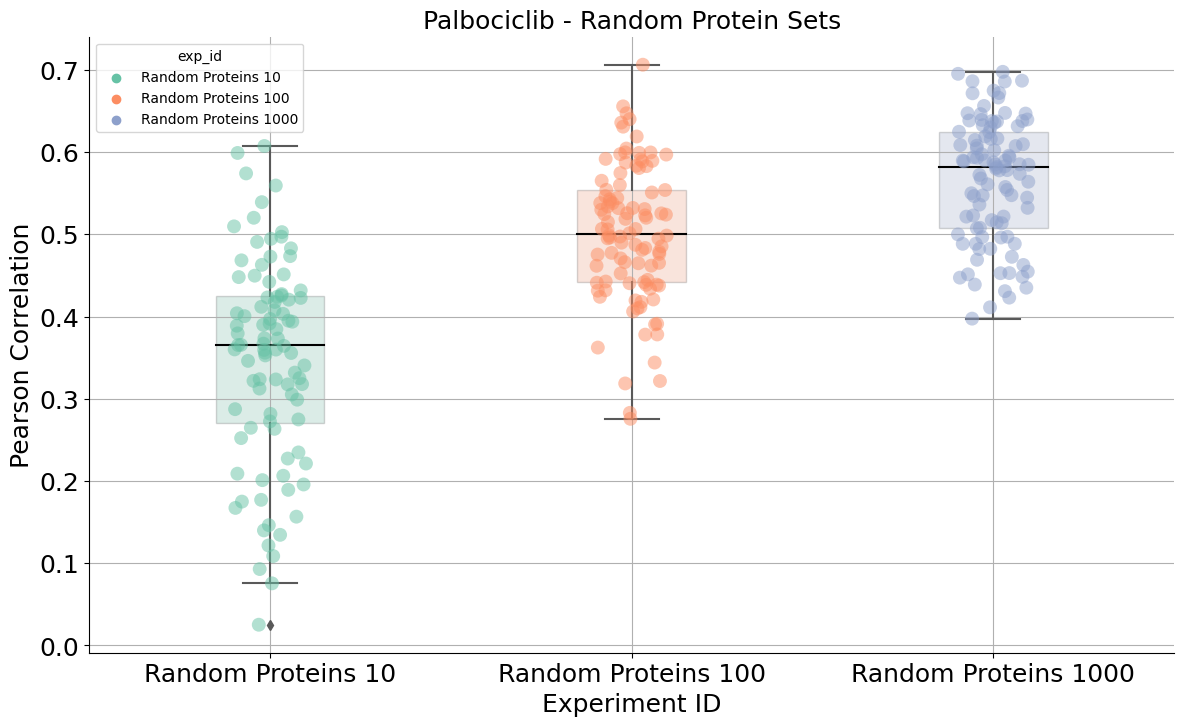

In [31]:
# plot collection df as a boxplot

import seaborn as sns
import matplotlib.pyplot as plt

import Visualisation as vis

fig, ax = plt.subplots(figsize=(14, 8))

vis.plot_box_plot(collection_df_random_proteome, 'exp_id', 'pearson_corr', 'Palbociclib - Random Protein Sets',
                  'Experiment ID', 'Pearson Correlation', ax=ax)


plt.grid()
sns.despine()
# show the plot
plt.show()


In [32]:

# combine above df with random df using pd.concat 

collection_df_random_proteome_combined = pd.concat([collection_df_freg_proteome, collection_df_random_proteome], ignore_index=True)

In [33]:
collection_df_random_proteome_combined.head()

,exp_id,random_seed,score,y_pred,y_test,selected_features,pearson_corr,pearson_p_val,r_squared
0,ANOVA Proteins 10,525,1.786280,"[4.073738998276902, 2.187193533553749, 2.50749...","[5.588066, 1.262779, -0.374178, 5.121886, 6.17...","[Q13422;IKZF1_HUMAN, P02545;LMNA_HUMAN, Q07157...",0.527896,1.342365e-06,0.254996
1,ANOVA Proteins 100,525,1.706123,"[4.321319772881839, 2.0699932526246823, 2.6087...","[5.588066, 1.262779, -0.374178, 5.121886, 6.17...","[P35221;CTNA1_HUMAN, Q15149;PLEC_HUMAN, O60716...",0.550001,3.857749e-07,0.288427
2,ANOVA Proteins 1000,525,1.639248,"[4.311369356259142, 2.028307056623743, 2.46632...","[5.588066, 1.262779, -0.374178, 5.121886, 6.17...","[P37108;SRP14_HUMAN, P36578;RL4_HUMAN, Q9P258;...",0.575349,8.229839e-08,0.316318
3,All Proteins,525,1.569996,"[4.208978537460154, 2.038500954994663, 2.57542...","[5.588066, 1.262779, -0.374178, 5.121886, 6.17...","[P37108;SRP14_HUMAN, Q96JP5;ZFP91_HUMAN, Q9Y4H...",0.607258,9.678571e-09,0.345202
4,ANOVA Proteins 10,654,1.567880,"[2.423116777683988, 3.935403907720567, 4.06202...","[3.185551, 3.805877, 5.38933, 5.089028, 5.3358...","[O60716;CTND1_HUMAN, Q13422;IKZF1_HUMAN, Q0715...",0.624916,2.665402e-09,0.338113


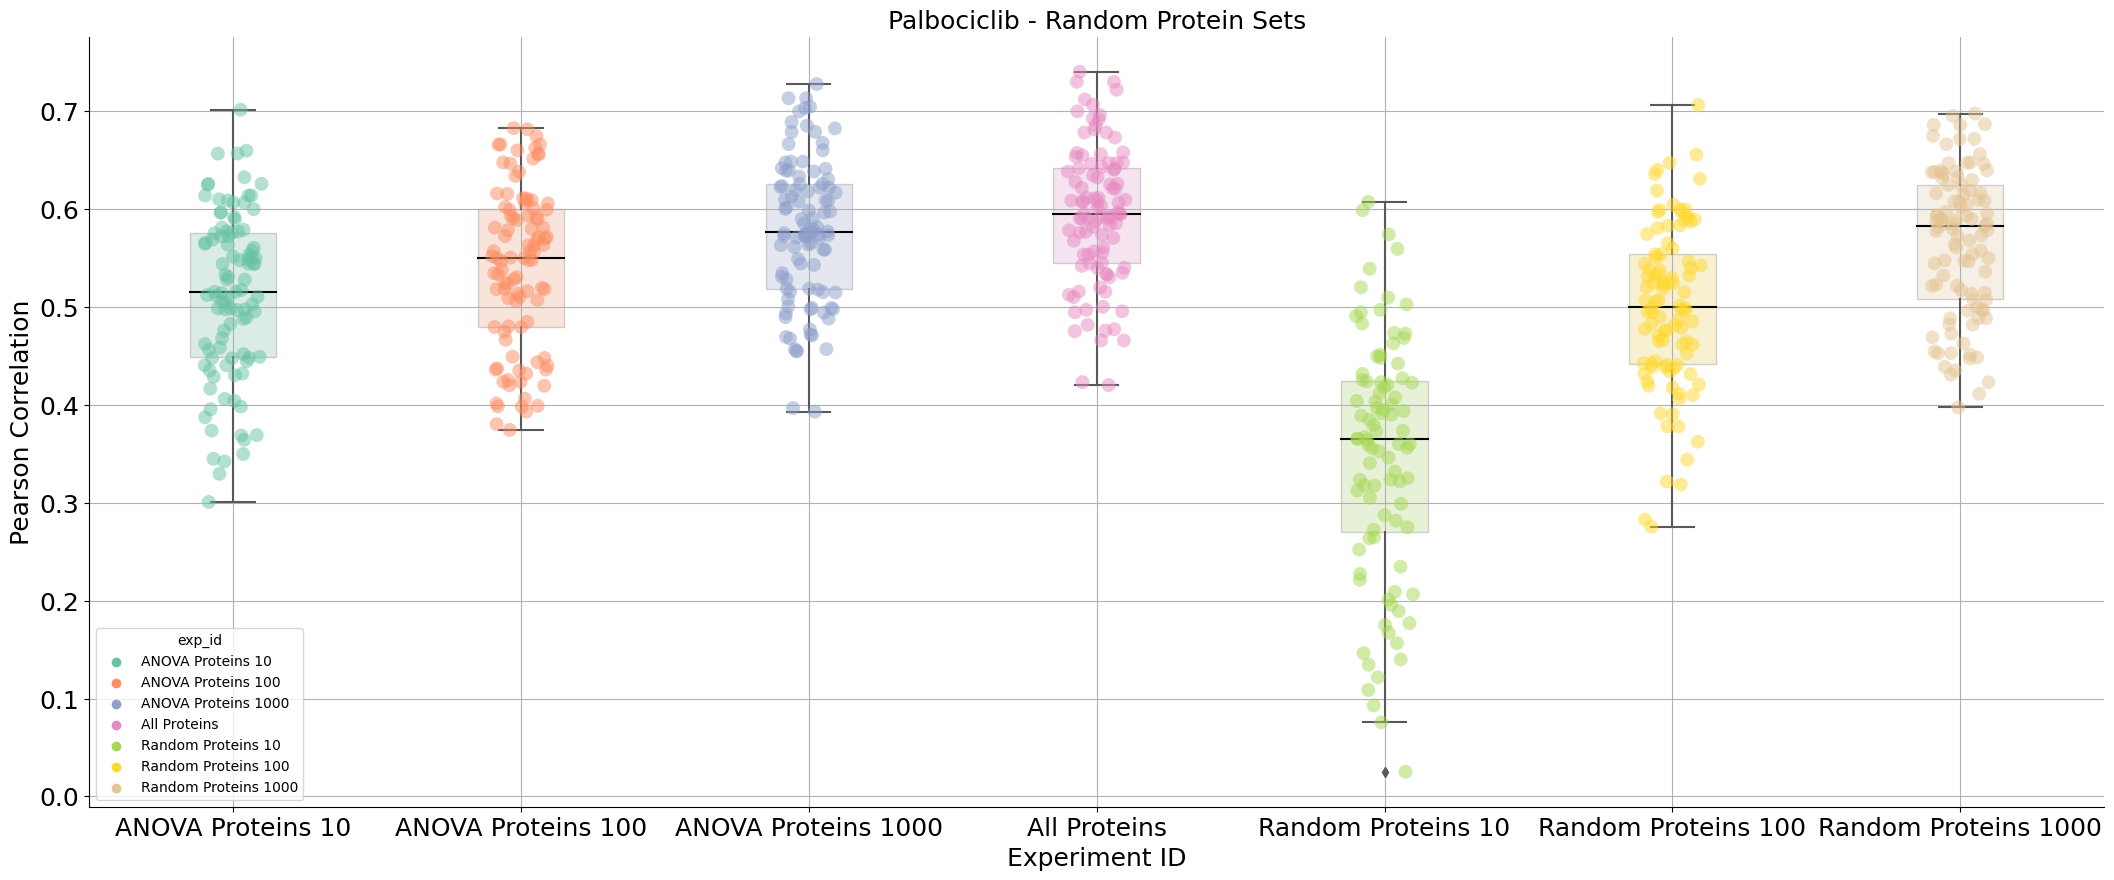

In [34]:
# visualise the combined df as a boxplot

fig, ax = plt.subplots(figsize=(26, 10))

vis.plot_box_plot(collection_df_random_proteome_combined, 'exp_id', 'pearson_corr', 'Palbociclib - Random Protein Sets',
                    'Experiment ID', 'Pearson Correlation', ax=ax)  

plt.grid()
sns.despine()

# show the plot
plt.show()

# Visualisation

visualisation should be independent from computation so to reduce unnecessary computing time, load everything from pickle caches 

In [35]:
# loading libraries

import Visualisation as vis
import matplotlib.pyplot as plt
import seaborn as sns

In [36]:
# load linear regression bulk run from pickle 

import pickle

with open('data/processed-results/elastic_net_fine_tune_results_ccle_palbociclib.pkl', 'rb') as f:
    collection_df_gene_fine_tune = pickle.load(f)

In [37]:
collection_df_gene_fine_tune.head()

,exp_id,random_seed,score,y_pred,y_test,selected_features,pearson_corr,pearson_p_val,r_squared
0,ANOVA 10 Genes (LR),519,1.259494,"[1.1740957548552455, 2.7871198051706045, 3.534...","[0.348878, 2.764856, 2.723005, 4.993982, 4.181...","[WAS, ARHGAP15, AMOTL2, NCKAP1L, SDC4, LAMA5, ...",0.710778,2.848080e-10,0.503251
1,ANOVA 100 Genes (LR),519,1.354956,"[1.7291481341587245, 2.713987983028508, 3.4936...","[0.348878, 2.764856, 2.723005, 4.993982, 4.181...","[TSPAN6, ITGAL, ITGA3, TNFRSF12A, BAIAP2L1, TR...",0.700671,6.488889e-10,0.465600
2,ANOVA 1000 Genes (LR),519,2.746715,"[1.9370972453094009, 1.0534405030152945, 3.599...","[0.348878, 2.764856, 2.723005, 4.993982, 4.181...","[TSPAN6, FGR, FUCA2, CD38, PRSS22, ITGAL, ITGA...",0.530287,1.561978e-05,-0.083315
3,All Genes (LR),519,1.441207,"[1.4440131596278256, 2.3537034380725466, 2.565...","[0.348878, 2.764856, 2.723005, 4.993982, 4.181...","[TSPAN6, TNMD, DPM1, SCYL3, C1orf112, FGR, CFH...",0.685445,2.108146e-09,0.431583
4,ANOVA 10 Genes (LR),316,1.827212,"[3.0637815153623897, 3.9567724484747195, 1.159...","[3.542085, 2.335321, 0.199181, 4.092189, 5.497...","[WAS, TJP1, AMOTL2, NCKAP1L, SDC4, SLC49A4, TU...",0.592863,7.518897e-07,0.346389


### Linear Regression Visualisation

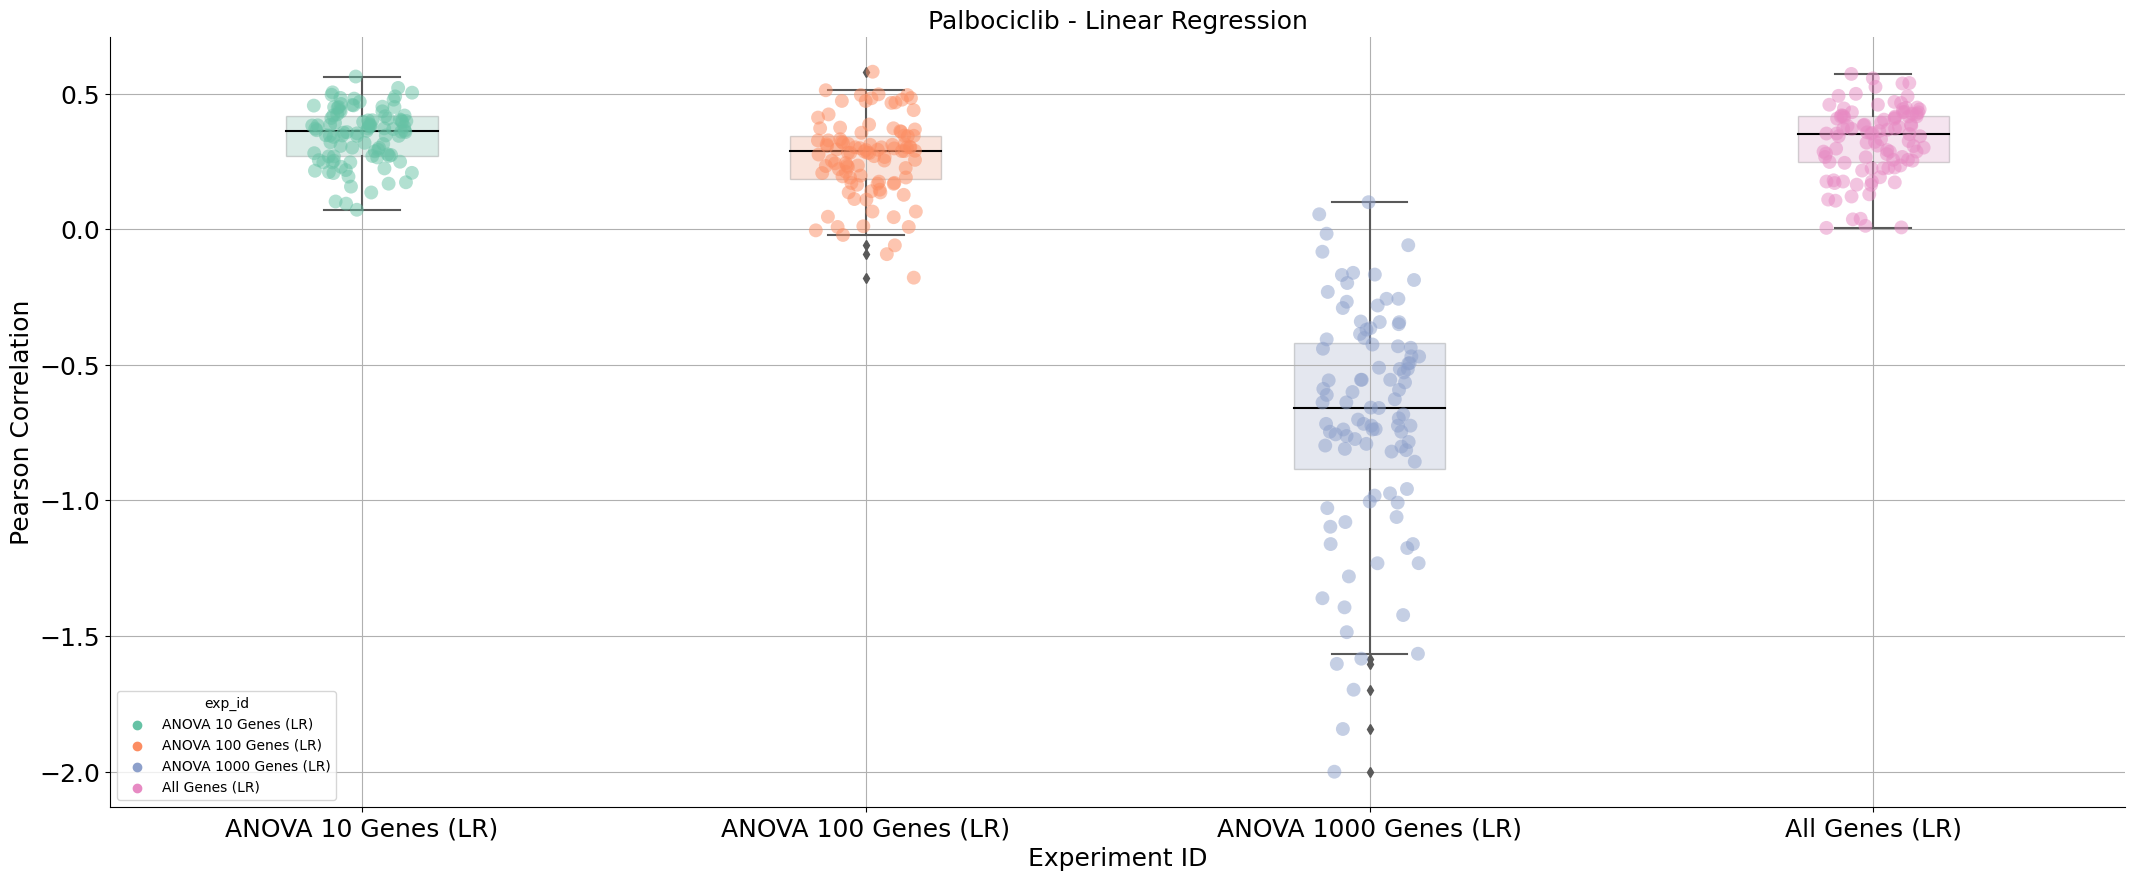

In [38]:
# visualise collection df as a boxplot

fig, ax = plt.subplots(figsize=(26, 10))

vis.plot_box_plot(collection_df_gene_fine_tune, 'exp_id', 'r_squared', 'Palbociclib - Linear Regression',
                    'Experiment ID', 'Pearson Correlation', ax=ax)          

plt.grid()
sns.despine()

# show the plot
plt.show()